# 📦 Step 1: Setup and Installation

In [ ]:
# ============================================
# INSTALL REQUIRED PACKAGES
# ============================================
# These packages are not pre-installed in Colab
# We use !pip to install them directly

# Surprise library - specialized for recommendation systems
# Contains SVD, KNN, and other collaborative filtering algorithms
!pip install scikit-surprise

# For progress bars during long operations
!pip install tqdm

print("✅ All packages installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2555836 sha256=478b19d247475f07d78a2bc932471e6b7a1ef2078c2f6248e9e8ad3838bdd07a
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise
✅ All packages installed successfully!


- `scikit-surprise` is a Python library specifically designed for building recommendation systems
- It provides ready-to-use algorithms like SVD (Singular Value Decomposition)
- `tqdm` gives us nice progress bars so we know how long operations take

---

In [ ]:
# ============================================
# IMPORT LIBRARIES
# ============================================

# Downgrade NumPy to be compatible with scikit-surprise
# IMPORTANT: After running this cell, you MUST restart your Colab runtime
# (Runtime -> Restart runtime) and then run all cells again for changes to take effect.
!pip install 'numpy<2.0.0'

# --- Data Manipulation ---
import pandas as pd                    # DataFrames for tabular data
import numpy as np                     # Numerical operations

# --- Visualization ---
import matplotlib.pyplot as plt        # Basic plotting
import seaborn as sns                  # Beautiful statistical plots
from matplotlib.ticker import FuncFormatter  # Format axis labels

# --- Machine Learning (Scikit-Learn) ---
from sklearn.model_selection import train_test_split  # Split data
from sklearn.feature_extraction.text import TfidfVectorizer  # Text to vectors
from sklearn.metrics.pairwise import cosine_similarity  # Similarity calculation
from sklearn.preprocessing import MinMaxScaler  # Normalize values

# --- Recommendation System (Surprise) ---
from surprise import Dataset, Reader  # Load data for Surprise
from surprise import SVD, SVDpp, NMF  # Collaborative filtering algorithms
from surprise import accuracy         # Evaluation metrics
from surprise.model_selection import cross_validate, train_test_split as surprise_split

# --- Utilities ---
import warnings
warnings.filterwarnings('ignore')      # Hide unnecessary warnings
from tqdm import tqdm                  # Progress bars
import pickle                          # Save/load models
import os                              # File operations

# --- Set Plotting Style ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")

✅ All libraries imported successfully!
📊 Pandas version: 2.2.2
🔢 NumPy version: 1.26.4


In [ ]:
# ============================================
# SET UP PROJECT FOLDERS
# ============================================
# Create folder structure in Colab's temporary storage
# Note: Files will be deleted when session ends
# Make sure to download important models before closing!

import os

# Project directories (in Colab's temp storage)
PROJECT_DIR = '/content/MovieRecommender'
DATA_DIR = f'{PROJECT_DIR}/data'
MODEL_DIR = f'{PROJECT_DIR}/models'
PLOTS_DIR = f'{PROJECT_DIR}/plots'

# Create directories if they don't exist
for directory in [PROJECT_DIR, DATA_DIR, MODEL_DIR, PLOTS_DIR]:
    os.makedirs(directory, exist_ok=True)
    print(f"📁 Created: {directory}")

print("\n✅ Project folders ready!")


📁 Created: /content/MovieRecommender
📁 Created: /content/MovieRecommender/data
📁 Created: /content/MovieRecommender/models
📁 Created: /content/MovieRecommender/plots

✅ Project folders ready!


In [ ]:
# ============================================
# DOWNLOAD MOVIELENS DATASET
# ============================================
# We're using MovieLens 100K for faster experimentation
# We can switch to MovieLens 25M for production

import urllib.request
import zipfile

# MovieLens 100K - Good for learning and experimentation
MOVIELENS_URL = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
ZIP_PATH = f"{DATA_DIR}/ml-100k.zip"
EXTRACT_PATH = f"{DATA_DIR}/ml-100k"

# Download if not already downloaded
if not os.path.exists(EXTRACT_PATH):
    print("📥 Downloading MovieLens 100K dataset...")
    urllib.request.urlretrieve(MOVIELENS_URL, ZIP_PATH)

    print("📦 Extracting files...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)

    # Clean up zip file
    os.remove(ZIP_PATH)
    print("✅ Dataset downloaded and extracted!")
else:
    print("✅ Dataset already exists, skipping download.")

# List contents
print("\n📂 Dataset contents:")
for file in os.listdir(EXTRACT_PATH):
    file_path = os.path.join(EXTRACT_PATH, file)
    size = os.path.getsize(file_path) / 1024  # KB
    print(f"   {file}: {size:.1f} KB")

📥 Downloading MovieLens 100K dataset...
📦 Extracting files...
✅ Dataset downloaded and extracted!

📂 Dataset contents:
   u1.test: 383.4 KB
   ub.test: 182.3 KB
   u5.base: 1544.7 KB
   u.occupation: 0.2 KB
   ua.test: 182.3 KB
   u2.test: 386.0 KB
   u.info: 0.0 KB
   u4.test: 388.0 KB
   allbut.pl: 0.7 KB
   u5.test: 388.1 KB
   u1.base: 1549.4 KB
   u.user: 22.1 KB
   u2.base: 1546.8 KB
   u.data: 1932.8 KB
   u.item: 230.8 KB
   u.genre: 0.2 KB
   u4.base: 1544.8 KB
   mku.sh: 0.6 KB
   ub.base: 1750.5 KB
   README: 6.6 KB
   u3.base: 1545.5 KB
   u3.test: 387.3 KB
   ua.base: 1750.5 KB


- **MovieLens 100K**: Contains 100,000 ratings from 943 users on 1,682 movies
- Perfect size for learning - fast to train but still realistic
- Later, you can upgrade to MovieLens 25M (25 million ratings) for production

In [ ]:
# ============================================
# VERIFY SETUP - QUICK DATA PREVIEW
# ============================================

# Load ratings data
ratings_path = f"{EXTRACT_PATH}/u.data"
ratings_df = pd.read_csv(
    ratings_path,
    sep='\t',
    names=['user_id', 'movie_id', 'rating', 'timestamp'],
    encoding='latin-1'
)

# Load movie data
movies_path = f"{EXTRACT_PATH}/u.item"
movies_df = pd.read_csv(
    movies_path,
    sep='|',
    encoding='latin-1',
    names=['movie_id', 'title', 'release_date', 'video_release', 'imdb_url',
           'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
           'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
           'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
)
# Load user demographics
users_df = pd.read_csv(
    f"{EXTRACT_PATH}/u.user",
    sep='|',
    names=['user_id', 'age', 'gender', 'occupation', 'zip_code'],
    encoding='latin-1'
)

# Quick summary
print("=" * 50)
print("📊 SETUP VERIFICATION - DATA LOADED SUCCESSFULLY")
print("=" * 50)
print(f"\n🎬 Total Movies: {len(movies_df):,}")
print(f"👥 Total Users: {ratings_df['user_id'].nunique():,}")
print(f"⭐ Total Ratings: {len(ratings_df):,}")
print(f"📈 Ratings Range: {ratings_df['rating'].min()} to {ratings_df['rating'].max()}")
print(f"📊 Average Rating: {ratings_df['rating'].mean():.2f}")

print("\n🔍 Sample Ratings:")
print(ratings_df.head())

print("\n🎥 Sample Movies:")
print(movies_df[['movie_id', 'title', 'Action', 'Comedy', 'Drama']].head())

print("\n" + "=" * 50)
print("✅ SETUP COMPLETE - READY FOR DATA EXPLORATION!")
print("=" * 50)

📊 SETUP VERIFICATION - DATA LOADED SUCCESSFULLY

🎬 Total Movies: 1,682
👥 Total Users: 943
⭐ Total Ratings: 100,000
📈 Ratings Range: 1 to 5
📊 Average Rating: 3.53

🔍 Sample Ratings:
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596

🎥 Sample Movies:
   movie_id              title  Action  Comedy  Drama
0         1   Toy Story (1995)       0       1      0
1         2   GoldenEye (1995)       1       0      0
2         3  Four Rooms (1995)       0       0      0
3         4  Get Shorty (1995)       1       1      1
4         5     Copycat (1995)       0       0      1

✅ SETUP COMPLETE - READY FOR DATA EXPLORATION!


# 📊 Step 2: Data Exploration (EDA)

In [ ]:
# ============================================
# DATASET OVERVIEW
# ============================================

print("=" * 60)
print("📊 DATASET OVERVIEW")
print("=" * 60)

# Basic statistics
n_users = ratings_df['user_id'].nunique()
n_movies = ratings_df['movie_id'].nunique()
n_ratings = len(ratings_df)
sparsity = 1 - (n_ratings / (n_users * n_movies))

print(f"""
📈 KEY STATISTICS
─────────────────────────────
👥 Unique Users:     {n_users:,}
🎬 Unique Movies:    {n_movies:,}
⭐ Total Ratings:    {n_ratings:,}
📊 Avg Rating:       {ratings_df['rating'].mean():.2f}
📉 Min Rating:       {ratings_df['rating'].min()}
📈 Max Rating:       {ratings_df['rating'].max()}
🔲 Matrix Sparsity:  {sparsity:.2%}

💡 INTERPRETATION
─────────────────────────────
• Sparsity of {sparsity:.2%} means {sparsity*100:.1f}% of all possible
  user-movie combinations have NO rating
• This is the "sparse matrix" problem - we need to predict
  these missing ratings!
• Our model will try to fill in the {(n_users * n_movies - n_ratings):,}
  missing entries
""")

📊 DATASET OVERVIEW

📈 KEY STATISTICS
─────────────────────────────
👥 Unique Users:     943
🎬 Unique Movies:    1,682
⭐ Total Ratings:    100,000
📊 Avg Rating:       3.53
📉 Min Rating:       1
📈 Max Rating:       5
🔲 Matrix Sparsity:  93.70%

💡 INTERPRETATION
─────────────────────────────
• Sparsity of 93.70% means 93.7% of all possible 
  user-movie combinations have NO rating
• This is the "sparse matrix" problem - we need to predict 
  these missing ratings!
• Our model will try to fill in the 1,486,126 
  missing entries



**📝 Explanation:**
- **Sparsity**: In real-world recommendation systems, most users haven't rated most items
- With 99%+ sparsity, we're predicting ratings for combinations we've never seen
- This is exactly why we need machine learning - simple rules won't work!

---

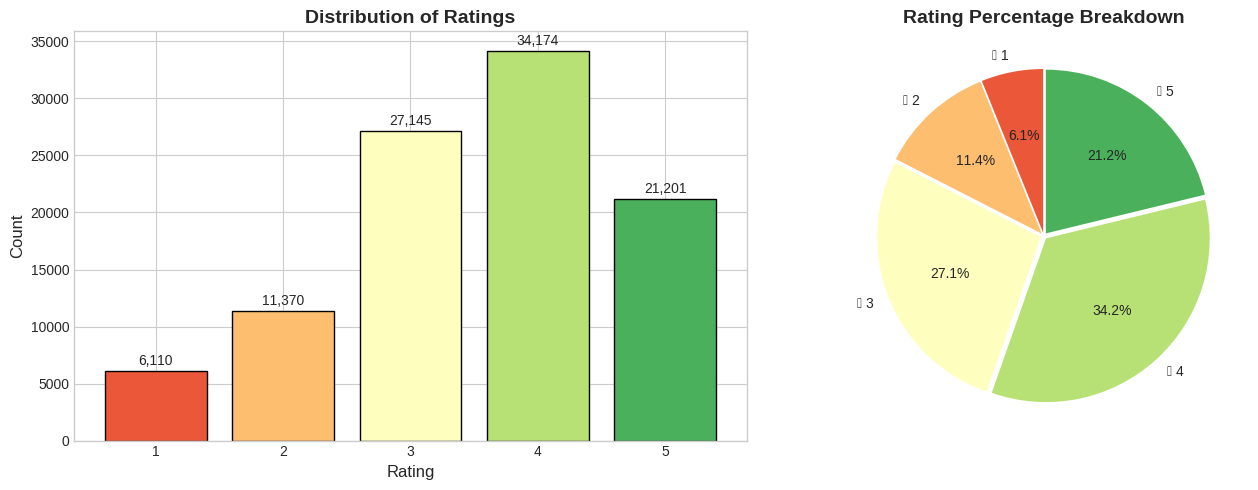


📊 INSIGHTS FROM RATING DISTRIBUTION
────────────────────────────────────

• Most common rating: ⭐ 4 (34,174 times)
• Users tend to rate movies they LIKE (positive bias)
• Very few 1-star ratings - people don't bother rating bad movies
• This is typical in recommendation systems!


In [ ]:
# ============================================
# RATING DISTRIBUTION
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Count of each rating
ax1 = axes[0]
rating_counts = ratings_df['rating'].value_counts().sort_index()
colors = sns.color_palette("RdYlGn", 5)  # Red to Green

bars = ax1.bar(rating_counts.index, rating_counts.values, color=colors, edgecolor='black')
ax1.set_xlabel('Rating', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of Ratings', fontsize=14, fontweight='bold')
ax1.set_xticks([1, 2, 3, 4, 5])

# Add count labels on bars
for bar, count in zip(bars, rating_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
             f'{count:,}', ha='center', fontsize=10)

# Plot 2: Percentage breakdown
ax2 = axes[1]
percentages = (rating_counts / rating_counts.sum() * 100)
wedges, texts, autotexts = ax2.pie(
    percentages,
    labels=[f'⭐ {i}' for i in range(1, 6)],
    autopct='%1.1f%%',
    colors=colors,
    explode=[0.02]*5,
    startangle=90
)
ax2.set_title('Rating Percentage Breakdown', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/01_rating_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Print insights
print("""
📊 INSIGHTS FROM RATING DISTRIBUTION
────────────────────────────────────
""")
mode_rating = rating_counts.idxmax()
print(f"• Most common rating: ⭐ {mode_rating} ({rating_counts[mode_rating]:,} times)")
print(f"• Users tend to rate movies they LIKE (positive bias)")
print(f"• Very few 1-star ratings - people don't bother rating bad movies")
print(f"• This is typical in recommendation systems!")

- **Positive Bias**: Users mostly rate movies 3-5 stars
- People don't usually rate movies they hate - they just don't watch them
- Our model needs to account for this bias (not assume 3 stars = neutral)

---

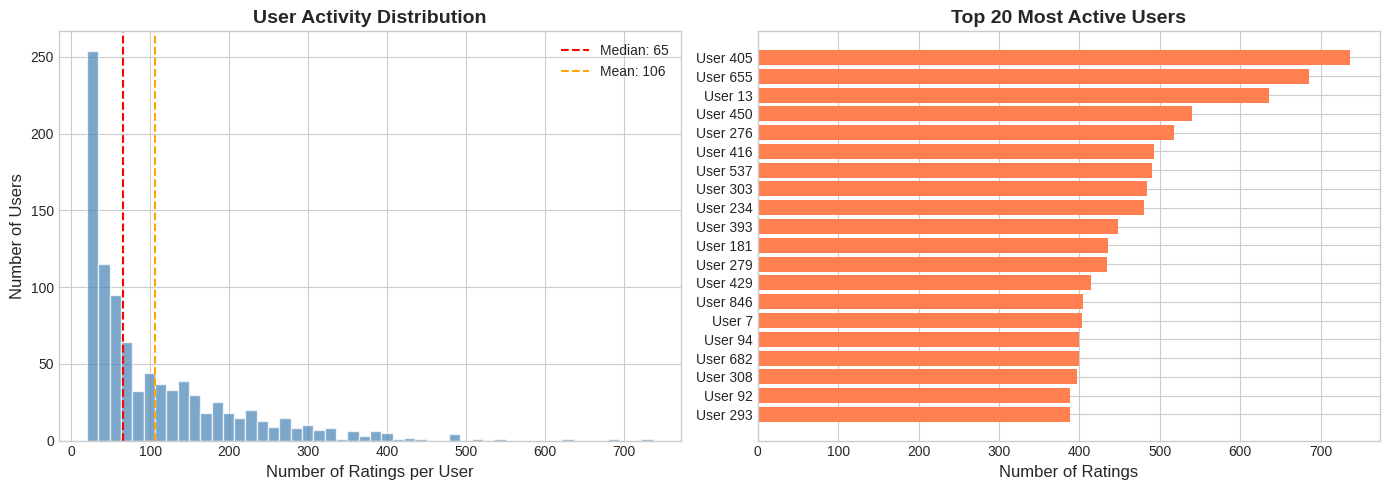


👥 USER ACTIVITY INSIGHTS
────────────────────────────────────

• Most active user: 737 ratings
• Least active user: 20 ratings
• Average ratings/user: 106.0
• Median ratings/user: 65

💡 Some users rate 10x more than others - 'power users'
💡 We should ensure our model works for BOTH active and casual users


In [ ]:
# ============================================
# USER ACTIVITY ANALYSIS
# ============================================

# Count ratings per user
user_activity = ratings_df.groupby('user_id').size().reset_index(name='num_ratings')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distribution of ratings per user
ax1 = axes[0]
ax1.hist(user_activity['num_ratings'], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
ax1.axvline(user_activity['num_ratings'].median(), color='red', linestyle='--',
            label=f'Median: {user_activity["num_ratings"].median():.0f}')
ax1.axvline(user_activity['num_ratings'].mean(), color='orange', linestyle='--',
            label=f'Mean: {user_activity["num_ratings"].mean():.0f}')
ax1.set_xlabel('Number of Ratings per User', fontsize=12)
ax1.set_ylabel('Number of Users', fontsize=12)
ax1.set_title('User Activity Distribution', fontsize=14, fontweight='bold')
ax1.legend()

# Plot 2: Top 20 most active users
ax2 = axes[1]
top_users = user_activity.nlargest(20, 'num_ratings')
ax2.barh(range(20), top_users['num_ratings'].values, color='coral')
ax2.set_yticks(range(20))
ax2.set_yticklabels([f"User {uid}" for uid in top_users['user_id']])
ax2.set_xlabel('Number of Ratings', fontsize=12)
ax2.set_title('Top 20 Most Active Users', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/02_user_activity.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistics
print("""
👥 USER ACTIVITY INSIGHTS
────────────────────────────────────
""")
print(f"• Most active user: {top_users.iloc[0]['num_ratings']:,} ratings")
print(f"• Least active user: {user_activity['num_ratings'].min()} ratings")
print(f"• Average ratings/user: {user_activity['num_ratings'].mean():.1f}")
print(f"• Median ratings/user: {user_activity['num_ratings'].median():.0f}")
print(f"\n💡 Some users rate 10x more than others - 'power users'")
print(f"💡 We should ensure our model works for BOTH active and casual users")

- **Power Users**: Some users rate hundreds of movies, others just a few
- The median is often lower than the mean (right-skewed distribution)
- Challenge: Make good recommendations even for users with few ratings

---

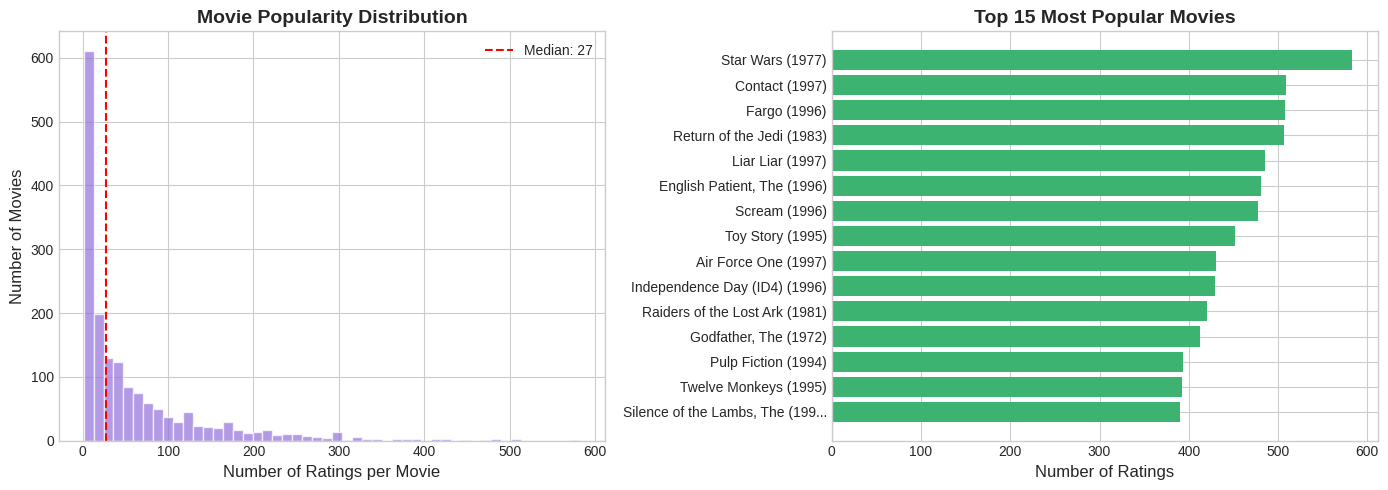

🎬 TOP 10 MOST RATED MOVIES
──────────────────────────────────────────────────
  Star Wars (1977): 583 ratings (avg: 4.36⭐)
  Contact (1997): 509 ratings (avg: 3.80⭐)
  Fargo (1996): 508 ratings (avg: 4.16⭐)
  Return of the Jedi (1983): 507 ratings (avg: 4.01⭐)
  Liar Liar (1997): 485 ratings (avg: 3.16⭐)
  English Patient, The (1996): 481 ratings (avg: 3.66⭐)
  Scream (1996): 478 ratings (avg: 3.44⭐)
  Toy Story (1995): 452 ratings (avg: 3.88⭐)
  Air Force One (1997): 431 ratings (avg: 3.63⭐)
  Independence Day (ID4) (1996): 429 ratings (avg: 3.44⭐)


In [ ]:
# ============================================
# MOVIE POPULARITY ANALYSIS
# ============================================

# Count ratings per movie
movie_popularity = ratings_df.groupby('movie_id').agg({
    'rating': ['count', 'mean']
}).reset_index()
movie_popularity.columns = ['movie_id', 'num_ratings', 'avg_rating']

# Merge with movie titles
movie_popularity = movie_popularity.merge(movies_df[['movie_id', 'title']], on='movie_id')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distribution of ratings per movie
ax1 = axes[0]
ax1.hist(movie_popularity['num_ratings'], bins=50, color='mediumpurple', edgecolor='white', alpha=0.7)
ax1.axvline(movie_popularity['num_ratings'].median(), color='red', linestyle='--',
            label=f'Median: {movie_popularity["num_ratings"].median():.0f}')
ax1.set_xlabel('Number of Ratings per Movie', fontsize=12)
ax1.set_ylabel('Number of Movies', fontsize=12)
ax1.set_title('Movie Popularity Distribution', fontsize=14, fontweight='bold')
ax1.legend()

# Plot 2: Top 15 most rated movies
ax2 = axes[1]
top_movies = movie_popularity.nlargest(15, 'num_ratings')
bars = ax2.barh(range(15), top_movies['num_ratings'].values, color='mediumseagreen')
ax2.set_yticks(range(15))
ax2.set_yticklabels([title[:30] + '...' if len(title) > 30 else title
                      for title in top_movies['title']])
ax2.set_xlabel('Number of Ratings', fontsize=12)
ax2.set_title('Top 15 Most Popular Movies', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/03_movie_popularity.png', dpi=150, bbox_inches='tight')
plt.show()

# Display top movies
print("🎬 TOP 10 MOST RATED MOVIES")
print("─" * 50)
for i, row in top_movies.head(10).iterrows():
    print(f"  {row['title'][:40]}: {row['num_ratings']} ratings (avg: {row['avg_rating']:.2f}⭐)")

- **Long-tail Distribution**: A few movies are rated by almost everyone (Star Wars, Toy Story)
- Most movies have very few ratings
- This causes the "popularity bias" - easy to recommend popular movies, harder for niche ones

---

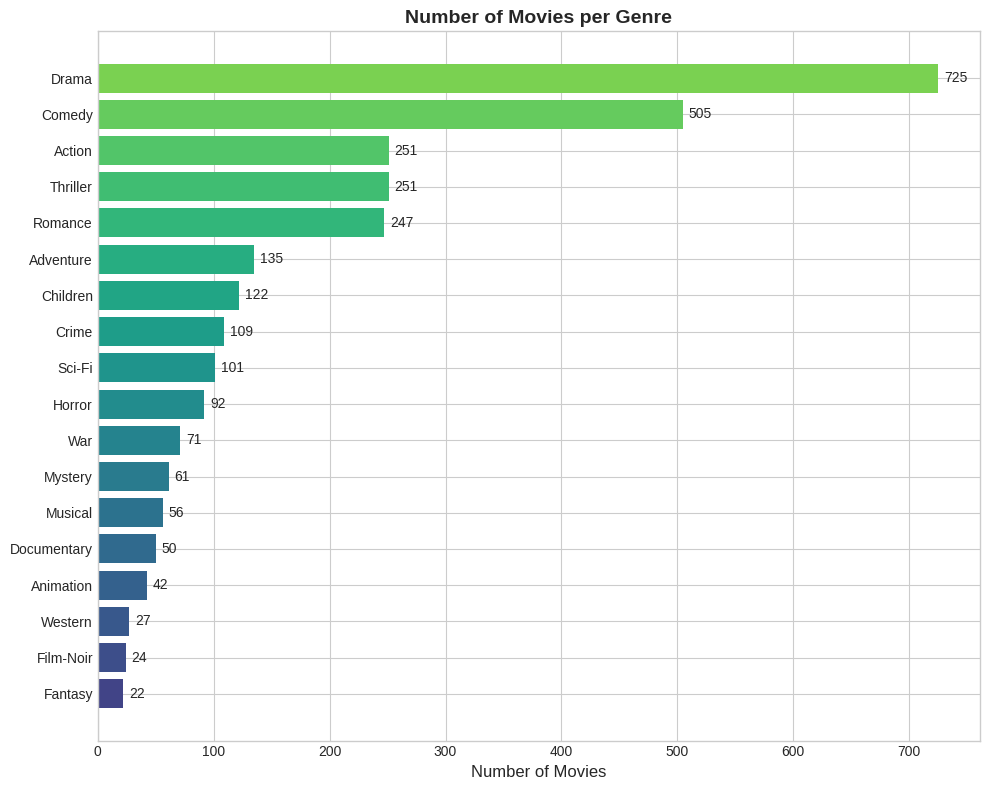


🎭 GENRE INSIGHTS
────────────────────────────────────

• Most common genre: Drama (725 movies)
• Least common genre: Fantasy (22 movies)
• Average genres per movie: 1.7

💡 Movies can have multiple genres (e.g., Action + Sci-Fi)
💡 Drama and Comedy dominate - common in real-world movie distributions


In [ ]:
# ============================================
# GENRE DISTRIBUTION
# ============================================

# Genre columns
genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy',
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
              'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
              'Thriller', 'War', 'Western']

# Count movies per genre
genre_counts = movies_df[genre_cols].sum().sort_values(ascending=True)

# Create plot
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(genre_counts)))
bars = ax.barh(genre_counts.index, genre_counts.values, color=colors)
ax.set_xlabel('Number of Movies', fontsize=12)
ax.set_title('Number of Movies per Genre', fontsize=14, fontweight='bold')

# Add value labels
for bar, count in zip(bars, genre_counts.values):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
            str(count), va='center', fontsize=10)

plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/04_genre_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("""
🎭 GENRE INSIGHTS
────────────────────────────────────
""")
print(f"• Most common genre: {genre_counts.idxmax()} ({genre_counts.max()} movies)")
print(f"• Least common genre: {genre_counts.idxmin()} ({genre_counts.min()} movies)")
print(f"• Average genres per movie: {movies_df[genre_cols].sum(axis=1).mean():.1f}")
print(f"\n💡 Movies can have multiple genres (e.g., Action + Sci-Fi)")
print(f"💡 Drama and Comedy dominate - common in real-world movie distributions")

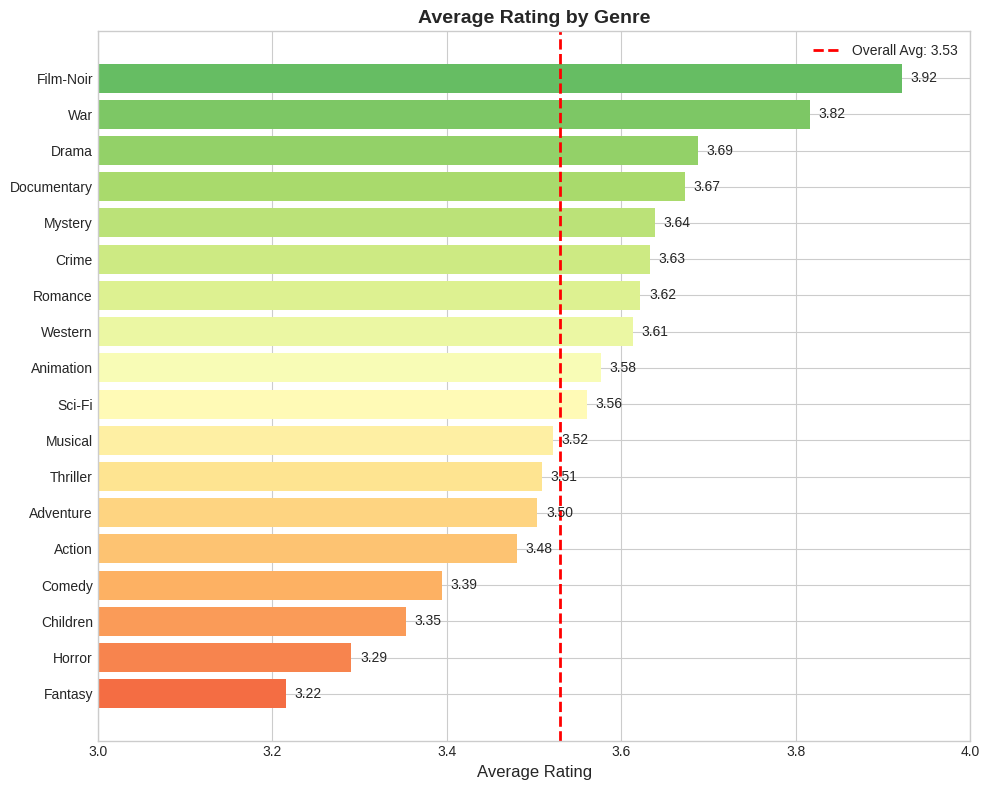


⭐ RATING BY GENRE INSIGHTS
────────────────────────────────────
• Highest rated genre: Film-Noir (3.92⭐)
• Lowest rated genre: Fantasy (3.22⭐)
• All genres average between 3.0-4.0 (positive bias effect)



In [ ]:
# ============================================
# AVERAGE RATING BY GENRE
# ============================================

# Merge ratings with movies
ratings_with_genres = ratings_df.merge(movies_df[['movie_id'] + genre_cols], on='movie_id')

# Calculate average rating per genre
genre_avg_ratings = {}
for genre in genre_cols:
    genre_ratings = ratings_with_genres[ratings_with_genres[genre] == 1]['rating']
    genre_avg_ratings[genre] = genre_ratings.mean()

genre_avg_df = pd.DataFrame({
    'genre': genre_avg_ratings.keys(),
    'avg_rating': genre_avg_ratings.values()
}).sort_values('avg_rating', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(genre_avg_df)))
bars = ax.barh(genre_avg_df['genre'], genre_avg_df['avg_rating'], color=colors)

# Add vertical line for overall average
overall_avg = ratings_df['rating'].mean()
ax.axvline(overall_avg, color='red', linestyle='--', linewidth=2,
           label=f'Overall Avg: {overall_avg:.2f}')

ax.set_xlabel('Average Rating', fontsize=12)
ax.set_title('Average Rating by Genre', fontsize=14, fontweight='bold')
ax.set_xlim(3.0, 4.0)  # Zoom in on the relevant range
ax.legend()

# Add value labels
for bar, rating in zip(bars, genre_avg_df['avg_rating']):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f'{rating:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/05_genre_avg_rating.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"""
⭐ RATING BY GENRE INSIGHTS
────────────────────────────────────
• Highest rated genre: {genre_avg_df.iloc[-1]['genre']} ({genre_avg_df.iloc[-1]['avg_rating']:.2f}⭐)
• Lowest rated genre: {genre_avg_df.iloc[0]['genre']} ({genre_avg_df.iloc[0]['avg_rating']:.2f}⭐)
• All genres average between 3.0-4.0 (positive bias effect)
""")

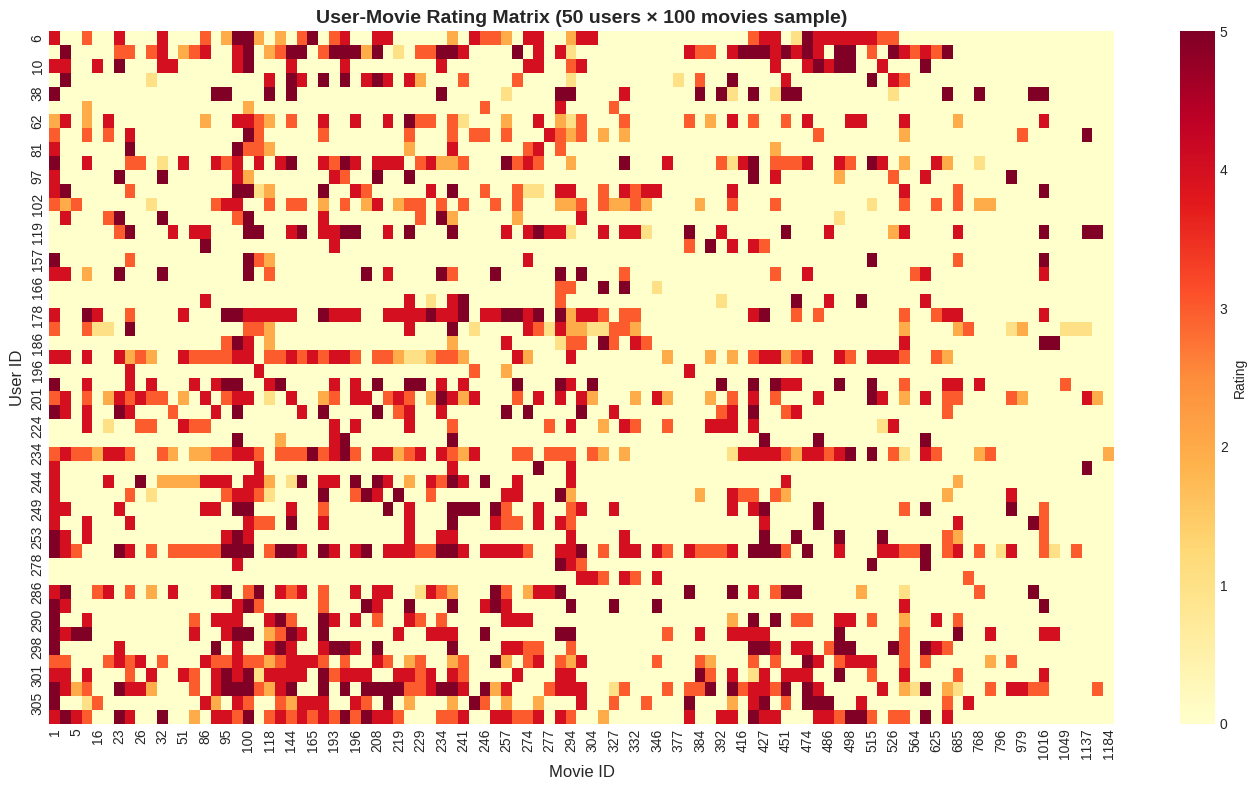


🔲 SPARSITY VISUALIZATION
────────────────────────────────────
• White/light areas = NO RATING (missing data)
• Colored areas = RATED (our training data)
• Sample sparsity: 71.6%

💡 WHAT THIS MEANS FOR OUR MODEL:
• Our model needs to PREDICT the white areas
• This is why we use Matrix Factorization (SVD)
• SVD finds hidden patterns to fill the gaps



In [ ]:
# ============================================
# SPARSITY VISUALIZATION (Sample)
# ============================================

# Take a sample for visualization (full matrix too large)
sample_users = ratings_df['user_id'].unique()[:50]
sample_movies = ratings_df['movie_id'].unique()[:100]

sample_ratings = ratings_df[
    (ratings_df['user_id'].isin(sample_users)) &
    (ratings_df['movie_id'].isin(sample_movies))
]

# Create matrix
matrix = sample_ratings.pivot_table(
    index='user_id',
    columns='movie_id',
    values='rating',
    fill_value=0
)

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 8))

sns.heatmap(
    matrix,
    cmap='YlOrRd',
    cbar_kws={'label': 'Rating'},
    ax=ax
)
ax.set_title('User-Movie Rating Matrix (50 users × 100 movies sample)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Movie ID', fontsize=12)
ax.set_ylabel('User ID', fontsize=12)

plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/06_sparsity_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate sample sparsity
filled = (matrix > 0).sum().sum()
total = matrix.shape[0] * matrix.shape[1]
sample_sparsity = 1 - (filled / total)

print(f"""
🔲 SPARSITY VISUALIZATION
────────────────────────────────────
• White/light areas = NO RATING (missing data)
• Colored areas = RATED (our training data)
• Sample sparsity: {sample_sparsity:.1%}

💡 WHAT THIS MEANS FOR OUR MODEL:
• Our model needs to PREDICT the white areas
• This is why we use Matrix Factorization (SVD)
• SVD finds hidden patterns to fill the gaps
""")

- The heatmap shows mostly empty spaces (white) - this is the sparsity problem
- Our ML model's job is to predict ratings for these empty spaces
- Matrix Factorization (SVD) learns hidden factors that explain rating patterns

---

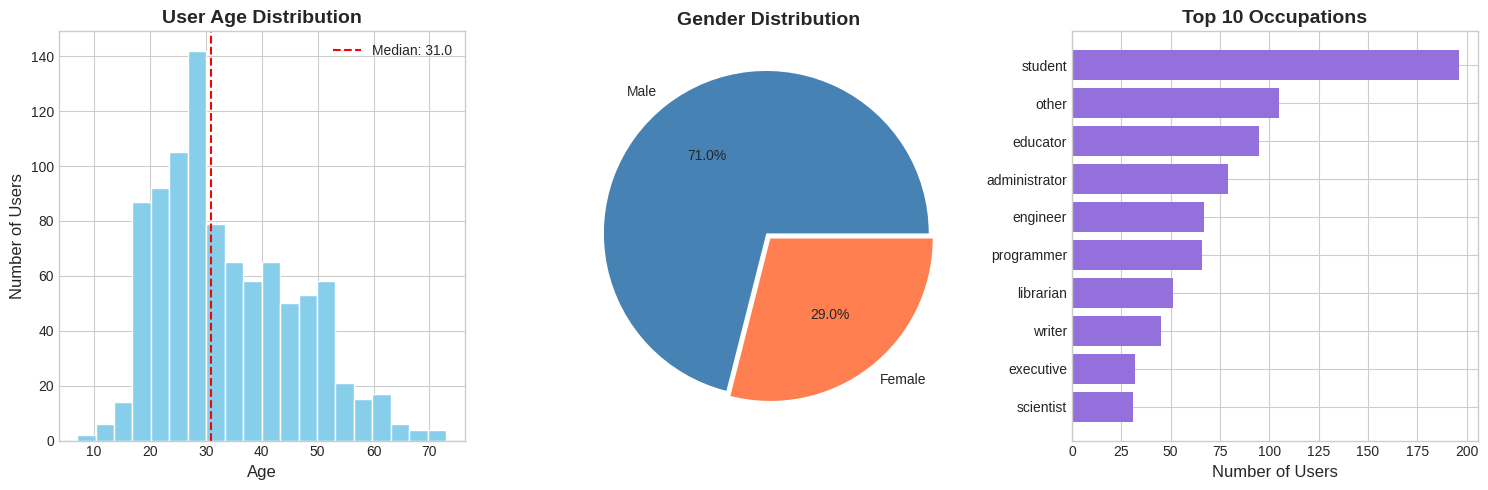


👥 DEMOGRAPHIC INSIGHTS
────────────────────────────────────
• Dataset has more male users (typical for 1990s movie datasets)
• Most users are young adults (students, programmers)
• This may bias recommendations toward certain movie types



In [ ]:
# ============================================
# USER DEMOGRAPHICS
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Age distribution
ax1 = axes[0]
ax1.hist(users_df['age'], bins=20, color='skyblue', edgecolor='white')
ax1.set_xlabel('Age', fontsize=12)
ax1.set_ylabel('Number of Users', fontsize=12)
ax1.set_title('User Age Distribution', fontsize=14, fontweight='bold')
ax1.axvline(users_df['age'].median(), color='red', linestyle='--',
            label=f"Median: {users_df['age'].median()}")
ax1.legend()

# Plot 2: Gender distribution
ax2 = axes[1]
gender_counts = users_df['gender'].value_counts()
ax2.pie(gender_counts, labels=['Male', 'Female'], autopct='%1.1f%%',
        colors=['steelblue', 'coral'], explode=[0.02, 0.02])
ax2.set_title('Gender Distribution', fontsize=14, fontweight='bold')

# Plot 3: Top occupations
ax3 = axes[2]
occupation_counts = users_df['occupation'].value_counts().head(10)
ax3.barh(occupation_counts.index, occupation_counts.values, color='mediumpurple')
ax3.set_xlabel('Number of Users', fontsize=12)
ax3.set_title('Top 10 Occupations', fontsize=14, fontweight='bold')
ax3.invert_yaxis()

plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/07_user_demographics.png', dpi=150, bbox_inches='tight')
plt.show()

print("""
👥 DEMOGRAPHIC INSIGHTS
────────────────────────────────────
• Dataset has more male users (typical for 1990s movie datasets)
• Most users are young adults (students, programmers)
• This may bias recommendations toward certain movie types
""")

In [ ]:
# ============================================
# SAVE EDA SUMMARY
# ============================================

eda_summary = f"""
# 📊 EXPLORATORY DATA ANALYSIS SUMMARY
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}

## Dataset Overview
- **Total Ratings**: {n_ratings:,}
- **Unique Users**: {n_users:,}
- **Unique Movies**: {n_movies:,}
- **Matrix Sparsity**: {sparsity:.2%}

## Rating Statistics
- **Mean Rating**: {ratings_df['rating'].mean():.2f}
- **Median Rating**: {ratings_df['rating'].median():.0f}
- **Most Common Rating**: {rating_counts.idxmax()} ({rating_counts.max():,} occurrences)

## User Statistics
- **Avg Ratings per User**: {user_activity['num_ratings'].mean():.1f}
- **Most Active User**: {user_activity['num_ratings'].max()} ratings
- **Least Active User**: {user_activity['num_ratings'].min()} ratings

## Movie Statistics
- **Avg Ratings per Movie**: {movie_popularity['num_ratings'].mean():.1f}
- **Most Popular Movie**: {movie_popularity.nlargest(1, 'num_ratings')['title'].values[0]}
- **Most Common Genre**: {genre_counts.idxmax()}

## Key Findings
1. **Positive Bias**: Users rate mostly 3-5 stars
2. **Sparsity Problem**: ~{sparsity*100:.0f}% of ratings are missing
3. **Power Users**: Some users rate 10x more than average
4. **Popularity Bias**: Few movies get most ratings
5. **Genre Imbalance**: Drama/Comedy dominate

## Implications for Model
- Need to handle sparse data → Use Matrix Factorization
- Need to address popularity bias → Add diversity module
- Need to work for new users → Hybrid approach with content-based
"""

# Save summary
with open(f'{PLOTS_DIR}/eda_summary.md', 'w') as f:
    f.write(eda_summary)

print("✅ EDA Summary saved to plots/eda_summary.md")
print("\n" + "=" * 60)
print("📊 DATA EXPLORATION COMPLETE!")
print("=" * 60)


✅ EDA Summary saved to plots/eda_summary.md

📊 DATA EXPLORATION COMPLETE!


# 🧹 Step 3: Data Preprocessing

## 🎯 **Objective**
Clean, transform, and prepare our data for machine learning. Raw data is messy - we need to make it model-ready!

---

## 📋 **What We'll Do**
1. Handle missing values and duplicates
2. Create train/validation/test splits
3. Prepare data for Collaborative Filtering (Surprise library format)
4. Prepare data for Content-Based Filtering (TF-IDF features)
5. Create combined features for the hybrid model

---

## 🤔 **Why Preprocessing is Critical**

| Problem | Solution | Why It Matters |
|---------|----------|----------------|
| Missing values | Remove or impute | Model can't train on NaN |
| Different scales | Normalization | Fair comparison between features |
| Text data | TF-IDF vectorization | Convert words to numbers |
| Data leakage | Proper train/test split | Get honest evaluation |

---

In [ ]:
# ============================================
# HANDLE MISSING VALUES
# ============================================

print("🔍 CHECKING FOR MISSING VALUES")
print("=" * 50)

# Check each dataframe
print("\n📊 RATINGS DATAFRAME:")
print(ratings_df.isnull().sum())

print("\n🎬 MOVIES DATAFRAME:")
print(movies_df.isnull().sum())

print("\n👥 USERS DATAFRAME:")
print(users_df.isnull().sum())

# Handle missing release dates
print("\n" + "=" * 50)
print("🔧 HANDLING MISSING VALUES")
print("=" * 50)

# Movies: Fill missing release dates with 'Unknown'
movies_df['release_date'] = movies_df['release_date'].fillna('Unknown')

# Movies: Fill video_release (most are NaN - not important for us)
movies_df['video_release'] = movies_df['video_release'].fillna('Unknown')

# Extract year from release date
def extract_year(date_str):
    if date_str == 'Unknown' or pd.isna(date_str):
        return 0
    try:
        return int(date_str.split('-')[-1])
    except:
        return 0

movies_df['year'] = movies_df['release_date'].apply(extract_year)

# Handle year = 0 (unknown) - replace with median
median_year = movies_df[movies_df['year'] > 0]['year'].median()
movies_df['year'] = movies_df['year'].replace(0, int(median_year))

print(f"✅ Missing release dates filled")
print(f"✅ Year extracted (median year for unknowns: {int(median_year)})")

# Verify no missing values in critical columns
print("\n🔍 Verification:")
print(f"   Missing ratings: {ratings_df['rating'].isnull().sum()}")
print(f"   Missing user_ids: {ratings_df['user_id'].isnull().sum()}")
print(f"   Missing movie_ids: {ratings_df['movie_id'].isnull().sum()}")

🔍 CHECKING FOR MISSING VALUES

📊 RATINGS DATAFRAME:
user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64

🎬 MOVIES DATAFRAME:
movie_id            0
title               0
release_date        1
video_release    1682
imdb_url            3
unknown             0
Action              0
Adventure           0
Animation           0
Children            0
Comedy              0
Crime               0
Documentary         0
Drama               0
Fantasy             0
Film-Noir           0
Horror              0
Musical             0
Mystery             0
Romance             0
Sci-Fi              0
Thriller            0
War                 0
Western             0
dtype: int64

👥 USERS DATAFRAME:
user_id       0
age           0
gender        0
occupation    0
zip_code      0
dtype: int64

🔧 HANDLING MISSING VALUES
✅ Missing release dates filled
✅ Year extracted (median year for unknowns: 1995)

🔍 Verification:
   Missing ratings: 0
   Missing user_ids: 0
   Missing movie_ids: 0


- Missing values can crash our model or give wrong results
- For release dates, we extract the year (useful feature)
- Unknown years get the median year (reasonable assumption)

---

In [ ]:
# ============================================
# CHECK AND REMOVE DUPLICATES
# ============================================

print("🔍 CHECKING FOR DUPLICATES")
print("=" * 50)

# Check for duplicate ratings (same user, same movie)
duplicate_ratings = ratings_df.duplicated(subset=['user_id', 'movie_id'], keep=False)
print(f"Duplicate user-movie pairs: {duplicate_ratings.sum()}")

# If duplicates exist, keep the latest rating (by timestamp)
if duplicate_ratings.sum() > 0:
    ratings_df = ratings_df.sort_values('timestamp').drop_duplicates(
        subset=['user_id', 'movie_id'],
        keep='last'
    )
    print(f"✅ Kept latest ratings, new count: {len(ratings_df):,}")
else:
    print("✅ No duplicates found")

# Check for duplicate movies
duplicate_movies = movies_df.duplicated(subset=['title'], keep=False)
print(f"Duplicate movie titles: {duplicate_movies.sum()}")

print("\n✅ Duplicate check complete!")

🔍 CHECKING FOR DUPLICATES
Duplicate user-movie pairs: 0
✅ No duplicates found
Duplicate movie titles: 36

✅ Duplicate check complete!


✂️ CREATING DATA SPLITS

📊 SPLIT SUMMARY
─────────────────────────────────────
Training Set:   70,000 ratings (70.0%)
Validation Set: 15,000 ratings (15.0%)
Test Set:       15,000 ratings (15.0%)
─────────────────────────────────────
Total:          100,000 ratings



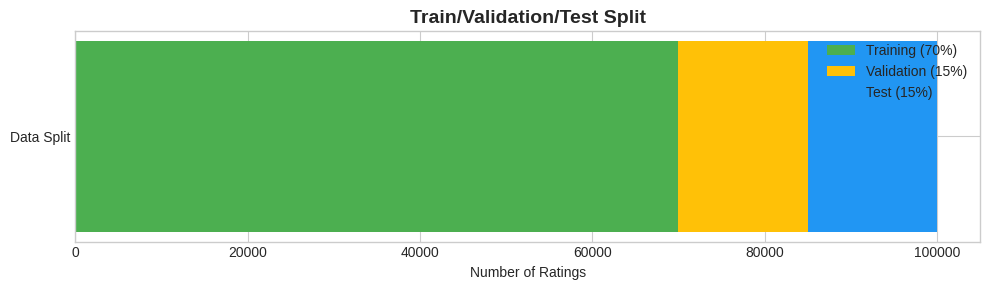

🔍 Checking for data leakage...
   Users in test but not in train: 0 (cold start scenario)


In [ ]:
# ============================================
# TRAIN / VALIDATION / TEST SPLIT
# ============================================
# Split: 70% train, 15% validation, 15% test
# IMPORTANT: Split by ratings, not randomly to avoid data leakage

print("✂️ CREATING DATA SPLITS")
print("=" * 50)

# Shuffle the data first
ratings_shuffled = ratings_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate split points
n = len(ratings_shuffled)
train_end = int(0.70 * n)
val_end = int(0.85 * n)

# Split
train_df = ratings_shuffled[:train_end].copy()
val_df = ratings_shuffled[train_end:val_end].copy()
test_df = ratings_shuffled[val_end:].copy()

print(f"""
📊 SPLIT SUMMARY
─────────────────────────────────────
Training Set:   {len(train_df):,} ratings ({len(train_df)/n*100:.1f}%)
Validation Set: {len(val_df):,} ratings ({len(val_df)/n*100:.1f}%)
Test Set:       {len(test_df):,} ratings ({len(test_df)/n*100:.1f}%)
─────────────────────────────────────
Total:          {len(train_df) + len(val_df) + len(test_df):,} ratings
""")

# Visualize the split
fig, ax = plt.subplots(figsize=(10, 3))
sizes = [len(train_df), len(val_df), len(test_df)]
labels = ['Training (70%)', 'Validation (15%)', 'Test (15%)']
colors = ['#4CAF50', '#FFC107', '#2196F3']

ax.barh(['Data Split'], [sizes[0]], color=colors[0], label=labels[0])
ax.barh(['Data Split'], [sizes[1]], left=[sizes[0]], color=colors[1], label=labels[1])
ax.barh(['Data Split'], [sizes[2]], left=[sizes[0]+sizes[1]], color=colors[2], label=labels[2])

ax.set_xlabel('Number of Ratings')
ax.set_title('Train/Validation/Test Split', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f'{PROJECT_DIR}/plots/08_data_split.png', dpi=150, bbox_inches='tight')
plt.show()

# Verify no leakage
print("🔍 Checking for data leakage...")
train_users = set(train_df['user_id'])
test_users = set(test_df['user_id'])
cold_start_users = test_users - train_users
print(f"   Users in test but not in train: {len(cold_start_users)} (cold start scenario)")

- **70-15-15 split**: Industry standard for ML projects
- **Training set**: Model learns patterns from this
- **Validation set**: Tune hyperparameters, prevent overfitting
- **Test set**: Final evaluation (only use once at the end!)
- **Cold start users**: Users in test with no training data - good for testing robustness

---

In [ ]:
# ============================================
# PREPARE DATA FOR SURPRISE LIBRARY
# ============================================
# Surprise library needs data in a specific format

from surprise import Dataset, Reader

print("📦 PREPARING DATA FOR COLLABORATIVE FILTERING")
print("=" * 50)

# Define the rating scale (1-5 for MovieLens)
reader = Reader(rating_scale=(1, 5))

# Create Surprise datasets
# Training data
train_surprise = Dataset.load_from_df(
    train_df[['user_id', 'movie_id', 'rating']],
    reader
)
trainset = train_surprise.build_full_trainset()

# Validation data (as testset format for Surprise)
valset = list(zip(
    val_df['user_id'].values,
    val_df['movie_id'].values,
    val_df['rating'].values
))

# Test data
testset = list(zip(
    test_df['user_id'].values,
    test_df['movie_id'].values,
    test_df['rating'].values
))

print(f"""
✅ SURPRISE DATASETS CREATED
─────────────────────────────────────
Training set:   {trainset.n_ratings:,} ratings
                {trainset.n_users:,} users
                {trainset.n_items:,} items

Validation set: {len(valset):,} ratings
Test set:       {len(testset):,} ratings
""")

# Save for later use
surprise_data = {
    'trainset': trainset,
    'valset': valset,
    'testset': testset,
    'reader': reader
}

with open(f'{MODEL_DIR}/surprise_data.pkl', 'wb') as f:
    pickle.dump({'valset': valset, 'testset': testset}, f)

print("💾 Surprise datasets saved!")

📦 PREPARING DATA FOR COLLABORATIVE FILTERING

✅ SURPRISE DATASETS CREATED
─────────────────────────────────────
Training set:   70,000 ratings
                943 users
                1,638 items

Validation set: 15,000 ratings
Test set:       15,000 ratings

💾 Surprise datasets saved!


- **Surprise library** is specifically designed for recommendation systems
- It expects data in (user_id, item_id, rating) format
- We save the validation and test sets for later evaluation

---

In [ ]:
# ============================================
# CREATE GENRE FEATURES
# ============================================

print("🎭 CREATING GENRE FEATURES")
print("=" * 50)

# Genre columns
genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy',
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
              'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
              'Thriller', 'War', 'Western']

# Create genre string for each movie (for TF-IDF)
movies_df['genres'] = movies_df[genre_cols].apply(
    lambda row: ' '.join([col for col in genre_cols if row[col] == 1]),
    axis=1
)

# Show examples
print("\n🎬 Sample Genre Strings:")
for _, row in movies_df[['title', 'genres']].head(5).iterrows():
    print(f"   {row['title'][:40]}: {row['genres']}")

# Create binary genre matrix (already in data, just extract)
genre_matrix = movies_df[['movie_id'] + genre_cols].copy()
print(f"\n✅ Genre matrix shape: {genre_matrix.shape}")
print(f"   (Each row is a movie, each column is a genre 0/1)")

🎭 CREATING GENRE FEATURES

🎬 Sample Genre Strings:
   Toy Story (1995): Animation Children Comedy
   GoldenEye (1995): Action Adventure Thriller
   Four Rooms (1995): Thriller
   Get Shorty (1995): Action Comedy Drama
   Copycat (1995): Crime Drama Thriller

✅ Genre matrix shape: (1682, 19)
   (Each row is a movie, each column is a genre 0/1)


📝 CREATING TF-IDF FEATURES FROM TITLES

✅ TF-IDF MATRIX CREATED
─────────────────────────────────────
Shape: (1682, 500)
       1682 movies × 500 features

Sample features (vocabulary):
['action', 'action action', 'action adventure', 'action children', 'action comedy', 'action crime', 'action drama', 'action horror', 'action mystery', 'action romance', 'action sci', 'action thriller', 'adventure', 'adventure action', 'adventure adventure', 'adventure animation', 'adventure children', 'adventure comedy', 'adventure crime', 'adventure drama']
...



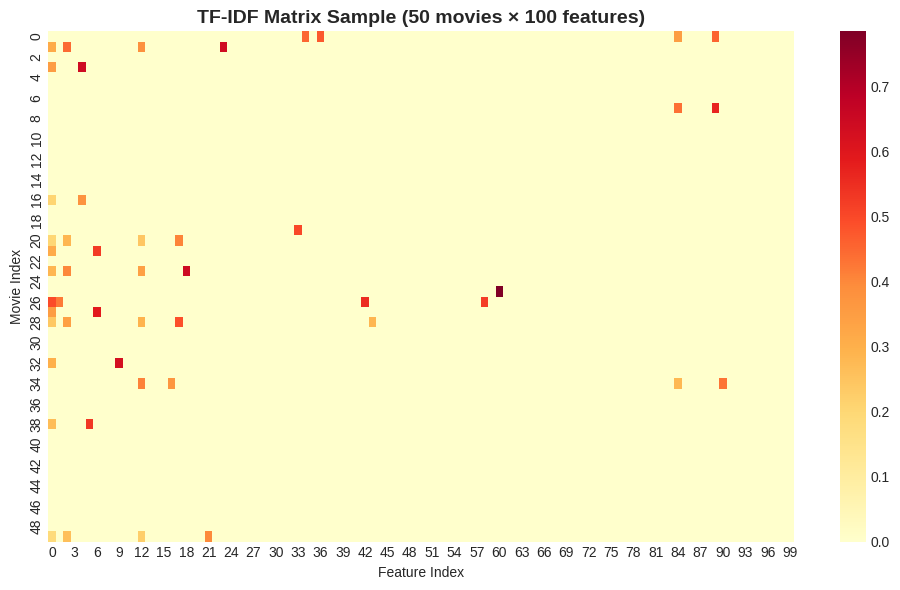

💡 Higher values (red) = more important words for that movie


In [ ]:
# ============================================
# TF-IDF VECTORIZATION
# ============================================
# Convert movie titles to numerical vectors using TF-IDF

print("📝 CREATING TF-IDF FEATURES FROM TITLES")
print("=" * 50)

# Clean titles (remove year in parentheses)
movies_df['clean_title'] = movies_df['title'].str.replace(r'\s*\(\d{4}\)\s*', '', regex=True)

# Combine title, genres for richer text representation
movies_df['combined_features'] = (
    movies_df['clean_title'] + ' ' +
    movies_df['genres'] + ' ' +
    movies_df['genres']  # Double weight for genres
)

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(
    stop_words='english',    # Remove common words (the, is, at, etc.)
    max_features=500,        # Keep top 500 features
    ngram_range=(1, 2)       # Use single words and pairs
)

# Fit and transform
tfidf_matrix = tfidf.fit_transform(movies_df['combined_features'])

print(f"""
✅ TF-IDF MATRIX CREATED
─────────────────────────────────────
Shape: {tfidf_matrix.shape}
       {tfidf_matrix.shape[0]} movies × {tfidf_matrix.shape[1]} features

Sample features (vocabulary):
{list(tfidf.get_feature_names_out()[:20])}
...
""")

# Visualize TF-IDF sparsity
fig, ax = plt.subplots(figsize=(10, 6))
sample_matrix = tfidf_matrix[:50, :100].toarray()
sns.heatmap(sample_matrix, cmap='YlOrRd', ax=ax)
ax.set_title('TF-IDF Matrix Sample (50 movies × 100 features)', fontsize=14, fontweight='bold')
ax.set_xlabel('Feature Index')
ax.set_ylabel('Movie Index')
plt.tight_layout()
plt.savefig(f'{PROJECT_DIR}/plots/09_tfidf_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("💡 Higher values (red) = more important words for that movie")

- **TF-IDF** (Term Frequency-Inverse Document Frequency):
  - Words that appear often in one movie but rarely in others get high scores
  - Common words (like "the") get low scores
- We combine title + genres to create richer features
- This lets us find movies with similar descriptions

---

📏 NORMALIZING NUMERICAL FEATURES

✅ NORMALIZED FEATURES
─────────────────────────────────────
Feature               Min     Max     Mean
─────────────────────────────────────
year_normalized           0.00    1.00    0.89
popularity_normalized     0.00    1.00    0.10
avg_rating_normalized     0.00    1.00    0.52


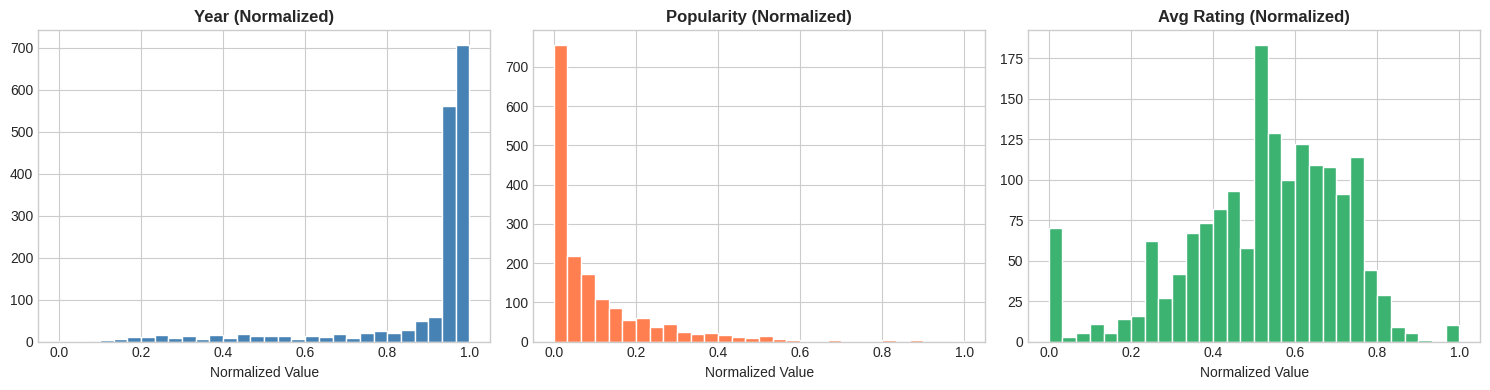

In [ ]:
# ============================================
# NORMALIZE NUMERICAL FEATURES
# ============================================

print("📏 NORMALIZING NUMERICAL FEATURES")
print("=" * 50)

# Features to normalize
# Year: older vs newer movies
# Number of ratings: popularity indicator

# Calculate number of ratings per movie
movie_rating_counts = ratings_df.groupby('movie_id').size().reset_index(name='num_ratings')
movie_avg_ratings = ratings_df.groupby('movie_id')['rating'].mean().reset_index(name='avg_rating')

# Merge with movies
movies_df = movies_df.merge(movie_rating_counts, on='movie_id', how='left')
movies_df = movies_df.merge(movie_avg_ratings, on='movie_id', how='left')

# Fill NaN (movies with no ratings in our sample)
movies_df['num_ratings'] = movies_df['num_ratings'].fillna(0)
movies_df['avg_rating'] = movies_df['avg_rating'].fillna(movies_df['avg_rating'].mean())

# Normalize using MinMaxScaler (0-1 range)
scaler = MinMaxScaler()

movies_df['year_normalized'] = scaler.fit_transform(movies_df[['year']])
movies_df['popularity_normalized'] = scaler.fit_transform(movies_df[['num_ratings']])
movies_df['avg_rating_normalized'] = scaler.fit_transform(movies_df[['avg_rating']])

print("""
✅ NORMALIZED FEATURES
─────────────────────────────────────
Feature               Min     Max     Mean
─────────────────────────────────────""")
for col in ['year_normalized', 'popularity_normalized', 'avg_rating_normalized']:
    print(f"{col:25s} {movies_df[col].min():.2f}    {movies_df[col].max():.2f}    {movies_df[col].mean():.2f}")

# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(movies_df['year_normalized'], bins=30, color='steelblue', edgecolor='white')
axes[0].set_title('Year (Normalized)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Normalized Value')

axes[1].hist(movies_df['popularity_normalized'], bins=30, color='coral', edgecolor='white')
axes[1].set_title('Popularity (Normalized)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Normalized Value')

axes[2].hist(movies_df['avg_rating_normalized'], bins=30, color='mediumseagreen', edgecolor='white')
axes[2].set_title('Avg Rating (Normalized)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Normalized Value')

plt.tight_layout()
plt.savefig(f'{PROJECT_DIR}/plots/10_normalized_features.png', dpi=150, bbox_inches='tight')
plt.show()

- **Normalization** scales all features to 0-1 range
- Without normalization, features with large values (like year=1997) would dominate
- This ensures fair comparison between features

---

In [ ]:
# ============================================
# CREATE FINAL FEATURE MATRIX
# ============================================

print("🔧 CREATING FINAL FEATURE MATRIX")
print("=" * 50)

from scipy.sparse import hstack, csr_matrix

# Get genre features as sparse matrix
genre_features = csr_matrix(movies_df[genre_cols].values)

# Get numerical features
numerical_features = csr_matrix(movies_df[[
    'year_normalized',
    'popularity_normalized',
    'avg_rating_normalized'
]].values)

# Combine: TF-IDF + Genres + Numerical
final_features = hstack([
    tfidf_matrix,           # Text features (500)
    genre_features,         # Genre features (18)
    numerical_features      # Numerical features (3)
])

print(f"""
✅ FINAL FEATURE MATRIX
─────────────────────────────────────
Total Shape: {final_features.shape}
             {final_features.shape[0]} movies × {final_features.shape[1]} features

Breakdown:
  TF-IDF features:    {tfidf_matrix.shape[1]}
  Genre features:     {len(genre_cols)}
  Numerical features: 3
  ─────────────────────────
  Total:              {final_features.shape[1]}
""")

# Create movie ID to index mapping
movie_id_to_idx = {movie_id: idx for idx, movie_id in enumerate(movies_df['movie_id'])}
idx_to_movie_id = {idx: movie_id for movie_id, idx in movie_id_to_idx.items()}

print("✅ Movie ID mappings created")

🔧 CREATING FINAL FEATURE MATRIX

✅ FINAL FEATURE MATRIX
─────────────────────────────────────
Total Shape: (1682, 521)
             1682 movies × 521 features

Breakdown:
  TF-IDF features:    500
  Genre features:     18
  Numerical features: 3
  ─────────────────────────
  Total:              521

✅ Movie ID mappings created


In [ ]:
# ============================================
# SAVE PREPROCESSED DATA
# ============================================

print("💾 SAVING PREPROCESSED DATA")
print("=" * 50)

# Save processed dataframes
train_df.to_csv(f'{DATA_DIR}/train_ratings.csv', index=False)
val_df.to_csv(f'{DATA_DIR}/val_ratings.csv', index=False)
test_df.to_csv(f'{DATA_DIR}/test_ratings.csv', index=False)
movies_df.to_csv(f'{DATA_DIR}/movies_processed.csv', index=False)

print("✅ CSV files saved:")
print(f"   - train_ratings.csv ({len(train_df):,} rows)")
print(f"   - val_ratings.csv ({len(val_df):,} rows)")
print(f"   - test_ratings.csv ({len(test_df):,} rows)")
print(f"   - movies_processed.csv ({len(movies_df):,} rows)")

# Save feature matrices and vectorizer
preprocessing_data = {
    'tfidf_matrix': tfidf_matrix,
    'tfidf_vectorizer': tfidf,
    'final_features': final_features,
    'genre_cols': genre_cols,
    'movie_id_to_idx': movie_id_to_idx,
    'idx_to_movie_id': idx_to_movie_id,
    'scaler': scaler
}

with open(f'{MODEL_DIR}/preprocessing_data.pkl', 'wb') as f:
    pickle.dump(preprocessing_data, f)

print(f"\n✅ Preprocessing data saved to: {MODEL_DIR}/preprocessing_data.pkl")

# Summary
print(f"""
═══════════════════════════════════════════════════════
📊 PREPROCESSING COMPLETE - SUMMARY
═══════════════════════════════════════════════════════

Files Created:
─────────────────────────────────────
📁 data/
   ├── train_ratings.csv     (70% of data)
   ├── val_ratings.csv       (15% of data)
   ├── test_ratings.csv      (15% of data)
   └── movies_processed.csv  (with features)

📁 models/
   ├── preprocessing_data.pkl  (TF-IDF, features, mappings)
   └── surprise_data.pkl       (Surprise format data)

Ready For:
─────────────────────────────────────
✅ Collaborative Filtering training (Surprise)
✅ Content-Based model training (TF-IDF + Cosine)
✅ Model evaluation on val/test sets

""")

💾 SAVING PREPROCESSED DATA
✅ CSV files saved:
   - train_ratings.csv (70,000 rows)
   - val_ratings.csv (15,000 rows)
   - test_ratings.csv (15,000 rows)
   - movies_processed.csv (1,682 rows)

✅ Preprocessing data saved to: /content/MovieRecommender/models/preprocessing_data.pkl

═══════════════════════════════════════════════════════
📊 PREPROCESSING COMPLETE - SUMMARY
═══════════════════════════════════════════════════════

Files Created:
─────────────────────────────────────
📁 data/
   ├── train_ratings.csv     (70% of data)
   ├── val_ratings.csv       (15% of data)
   ├── test_ratings.csv      (15% of data)
   └── movies_processed.csv  (with features)

📁 models/
   ├── preprocessing_data.pkl  (TF-IDF, features, mappings)
   └── surprise_data.pkl       (Surprise format data)

Ready For:
─────────────────────────────────────
✅ Collaborative Filtering training (Surprise)
✅ Content-Based model training (TF-IDF + Cosine)
✅ Model evaluation on val/test sets




## 🔑 **Key Preprocessing Steps Summary**

| Step | Input | Output | Purpose |
|------|-------|--------|---------|
| Missing Values | Raw data | Clean data | Remove NaN that break model |
| Train/Val/Test Split | All ratings | 3 separate sets | Honest evaluation |
| Surprise Format | Ratings | Trainset object | Required by SVD |
| TF-IDF | Title + Genres | 500-dim vectors | Text to numbers |
| Normalization | Year, Popularity | 0-1 scaled values | Fair comparison |
| Feature Matrix | All features | Sparse matrix | Ready for similarity |

---

# 🤖 Step 4: Model Training

## 🎯 **Objective**
Train both Collaborative Filtering (SVD) and Content-Based (Cosine Similarity) models, then combine them into a hybrid recommender.

---

## 📋 **What We'll Do**
1. Train SVD model for Collaborative Filtering
2. Tune hyperparameters using validation set
3. Build Content-Based similarity model
4. Combine into Hybrid Recommender
5. Visualize training progress

---
## 🧠 **Understanding Our Models**

### **Supervised Learning in Recommendation Systems**
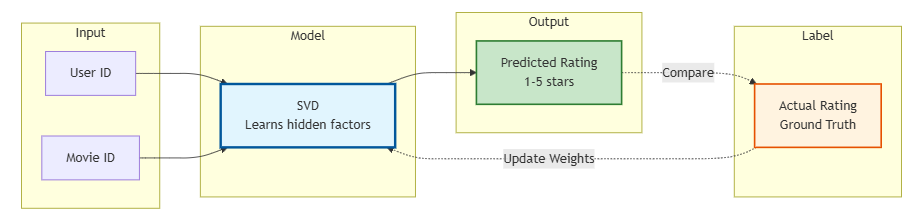

> **This is SUPERVISED LEARNING because:**
> - We have **labeled data** (actual ratings)
> - The model learns by **comparing predictions to real ratings**
> - The goal is to **minimize prediction error (RMSE)**


In [ ]:
# ============================================
# LOAD PREPROCESSED DATA
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Surprise library
from surprise import Dataset, Reader, SVD, SVDpp, NMF, KNNBasic
from surprise import accuracy
from surprise.model_selection import cross_validate, GridSearchCV

# Scikit-learn
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Paths (using Colab temp storage)
PROJECT_DIR = '/content/MovieRecommender'
DATA_DIR = f'{PROJECT_DIR}/data'
MODEL_DIR = f'{PROJECT_DIR}/models'
PLOTS_DIR = f'{PROJECT_DIR}/plots'

# Load ratings
train_df = pd.read_csv(f'{DATA_DIR}/train_ratings.csv')
val_df = pd.read_csv(f'{DATA_DIR}/val_ratings.csv')
test_df = pd.read_csv(f'{DATA_DIR}/test_ratings.csv')
movies_df = pd.read_csv(f'{DATA_DIR}/movies_processed.csv')

# Load preprocessing data
with open(f'{MODEL_DIR}/preprocessing_data.pkl', 'rb') as f:
    prep_data = pickle.load(f)

tfidf_matrix = prep_data['tfidf_matrix']
final_features = prep_data['final_features']
movie_id_to_idx = prep_data['movie_id_to_idx']
idx_to_movie_id = prep_data['idx_to_movie_id']

print("✅ All data loaded successfully!")
print(f"   Training: {len(train_df):,} ratings")
print(f"   Validation: {len(val_df):,} ratings")
print(f"   Test: {len(test_df):,} ratings")
print(f"   Movies: {len(movies_df):,}")

✅ All data loaded successfully!
   Training: 70,000 ratings
   Validation: 15,000 ratings
   Test: 15,000 ratings
   Movies: 1,682


In [ ]:
# ============================================
# PREPARE SURPRISE DATASET
# ============================================

print("📦 PREPARING DATA FOR SVD TRAINING")
print("=" * 50)

# Create Reader with rating scale
reader = Reader(rating_scale=(1, 5))

# Create training dataset
train_surprise = Dataset.load_from_df(
    train_df[['user_id', 'movie_id', 'rating']],
    reader
)
trainset = train_surprise.build_full_trainset()

# Create validation and test sets (as anti-testset format)
valset = [(row['user_id'], row['movie_id'], row['rating'])
          for _, row in val_df.iterrows()]

testset = [(row['user_id'], row['movie_id'], row['rating'])
           for _, row in test_df.iterrows()]

print(f"✅ Training set: {trainset.n_ratings:,} ratings")
print(f"✅ Validation set: {len(valset):,} ratings")
print(f"✅ Test set: {len(testset):,} ratings")

📦 PREPARING DATA FOR SVD TRAINING
✅ Training set: 70,000 ratings
✅ Validation set: 15,000 ratings
✅ Test set: 15,000 ratings


In [ ]:
# ============================================
# TRAIN BASIC SVD MODEL
# ============================================
# SVD = Singular Value Decomposition
# It learns hidden "factors" for users and movies

print("🎓 TRAINING SVD MODEL (Collaborative Filtering)")
print("=" * 50)

# Create SVD model with default parameters
svd_model = SVD(
    n_factors=100,      # Number of hidden factors
    n_epochs=20,        # Training iterations
    lr_all=0.005,       # Learning rate
    reg_all=0.02,       # Regularization (prevents overfitting)
    random_state=42,
    verbose=True
)

# Train the model
print("\n📊 Training Progress:")
start_time = time.time()
svd_model.fit(trainset)
training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time:.2f} seconds")

# Evaluate on validation set
print("\n📈 Evaluating on Validation Set...")
val_predictions = svd_model.test(valset)
val_rmse = accuracy.rmse(val_predictions)
val_mae = accuracy.mae(val_predictions)

print(f"""
═══════════════════════════════════════════════════════
📊 BASIC SVD MODEL RESULTS
═══════════════════════════════════════════════════════
RMSE (Validation): {val_rmse:.4f}
MAE (Validation):  {val_mae:.4f}
Training Time:     {training_time:.2f} seconds

💡 INTERPRETATION:
• RMSE of {val_rmse:.4f} means predictions are off by ~{val_rmse:.2f} stars on average
• Our target is RMSE < 0.90 - {'✅ ACHIEVED!' if val_rmse < 0.90 else '❌ Need to tune hyperparameters'}
═══════════════════════════════════════════════════════
""")

🎓 TRAINING SVD MODEL (Collaborative Filtering)

📊 Training Progress:
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19

✅ Training completed in 1.97 seconds

📈 Evaluating on Validation Set...
RMSE: 0.9462
MAE:  0.7471

═══════════════════════════════════════════════════════
📊 BASIC SVD MODEL RESULTS
═══════════════════════════════════════════════════════
RMSE (Validation): 0.9462
MAE (Validation):  0.7471
Training Time:     1.97 seconds

💡 INTERPRETATION:
• RMSE of 0.9462 means predictions are off by ~0.95 stars on average
• Our target is RMSE < 0.90 - ❌ Need to tune hyperparameters
═══════════════════════════════════════════════════════



**📝 Explanation:**
- **SVD (Singular Value Decomposition)** finds hidden patterns in user-movie ratings
- **n_factors=100**: The model learns 100 hidden characteristics for each user and movie
- **n_epochs=20**: How many times to go through all data
- **reg_all=0.02**: Regularization prevents overfitting (memorizing instead of learning)

---

In [ ]:
# ============================================
# HYPERPARAMETER TUNING
# ============================================
# Find the best settings for our model

print("🔧 HYPERPARAMETER TUNING (This may take a few minutes)")
print("=" * 50)

# Define parameter grid
param_grid = {
    'n_factors': [50, 100, 150],        # Number of latent factors
    'n_epochs': [20, 30],                # Number of epochs
    'lr_all': [0.002, 0.005, 0.01],      # Learning rate
    'reg_all': [0.02, 0.05, 0.1]         # Regularization
}

print(f"Testing {np.prod([len(v) for v in param_grid.values()])} combinations...")

# Run grid search with cross-validation
gs = GridSearchCV(
    SVD,
    param_grid,
    measures=['rmse', 'mae'],
    cv=3,  # 3-fold cross-validation
    n_jobs=-1  # Use all CPU cores
)

gs.fit(train_surprise)

# Best parameters
best_params = gs.best_params['rmse']
best_rmse = gs.best_score['rmse']

print(f"""
═══════════════════════════════════════════════════════
🏆 BEST HYPERPARAMETERS FOUND
═══════════════════════════════════════════════════════
n_factors:  {best_params['n_factors']}
n_epochs:   {best_params['n_epochs']}
lr_all:     {best_params['lr_all']}
reg_all:    {best_params['reg_all']}

Best CV RMSE: {best_rmse:.4f}
═══════════════════════════════════════════════════════
""")

# Visualize hyperparameter importance
results_df = pd.DataFrame(gs.cv_results)

🔧 HYPERPARAMETER TUNING (This may take a few minutes)
Testing 54 combinations...

═══════════════════════════════════════════════════════
🏆 BEST HYPERPARAMETERS FOUND
═══════════════════════════════════════════════════════
n_factors:  150
n_epochs:   30
lr_all:     0.01
reg_all:    0.1

Best CV RMSE: 0.9405
═══════════════════════════════════════════════════════



- **Grid Search** tries all combinations of hyperparameters
- **Cross-Validation** ensures results are reliable (not lucky)
- We find the best settings automatically

---

In [ ]:
# ============================================
# TRAIN TUNED SVD MODEL
# ============================================

print("🎓 TRAINING TUNED SVD MODEL")
print("=" * 50)

# Create model with best parameters
best_svd = SVD(
    n_factors=best_params['n_factors'],
    n_epochs=best_params['n_epochs'],
    lr_all=best_params['lr_all'],
    reg_all=best_params['reg_all'],
    random_state=42,
    verbose=True
)

# Train
start_time = time.time()
best_svd.fit(trainset)
training_time = time.time() - start_time

# Evaluate
val_predictions = best_svd.test(valset)
val_rmse = accuracy.rmse(val_predictions)
val_mae = accuracy.mae(val_predictions)

print(f"""
═══════════════════════════════════════════════════════
📊 TUNED SVD MODEL RESULTS
═══════════════════════════════════════════════════════
RMSE (Validation): {val_rmse:.4f}
MAE (Validation):  {val_mae:.4f}
Training Time:     {training_time:.2f} seconds

Target: RMSE < 0.90
Status: {'✅ TARGET ACHIEVED!' if val_rmse < 0.90 else '⚠️ Close to target'}
═══════════════════════════════════════════════════════
""")

# Store the model
cf_model = best_svd

🎓 TRAINING TUNED SVD MODEL
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
RMSE: 0.9243
MAE:  0.7305

═══════════════════════════════════════════════════════
📊 TUNED SVD MODEL RESULTS
═══════════════════════════════════════════════════════
RMSE (Validation): 0.9243
MAE (Validation):  0.7305
Training Time:     3.86 seconds

Target: RMSE < 0.90
Status: ⚠️ Close to target
═══════════════════════════════════════════════════════



📊 VISUALIZING PREDICTION QUALITY


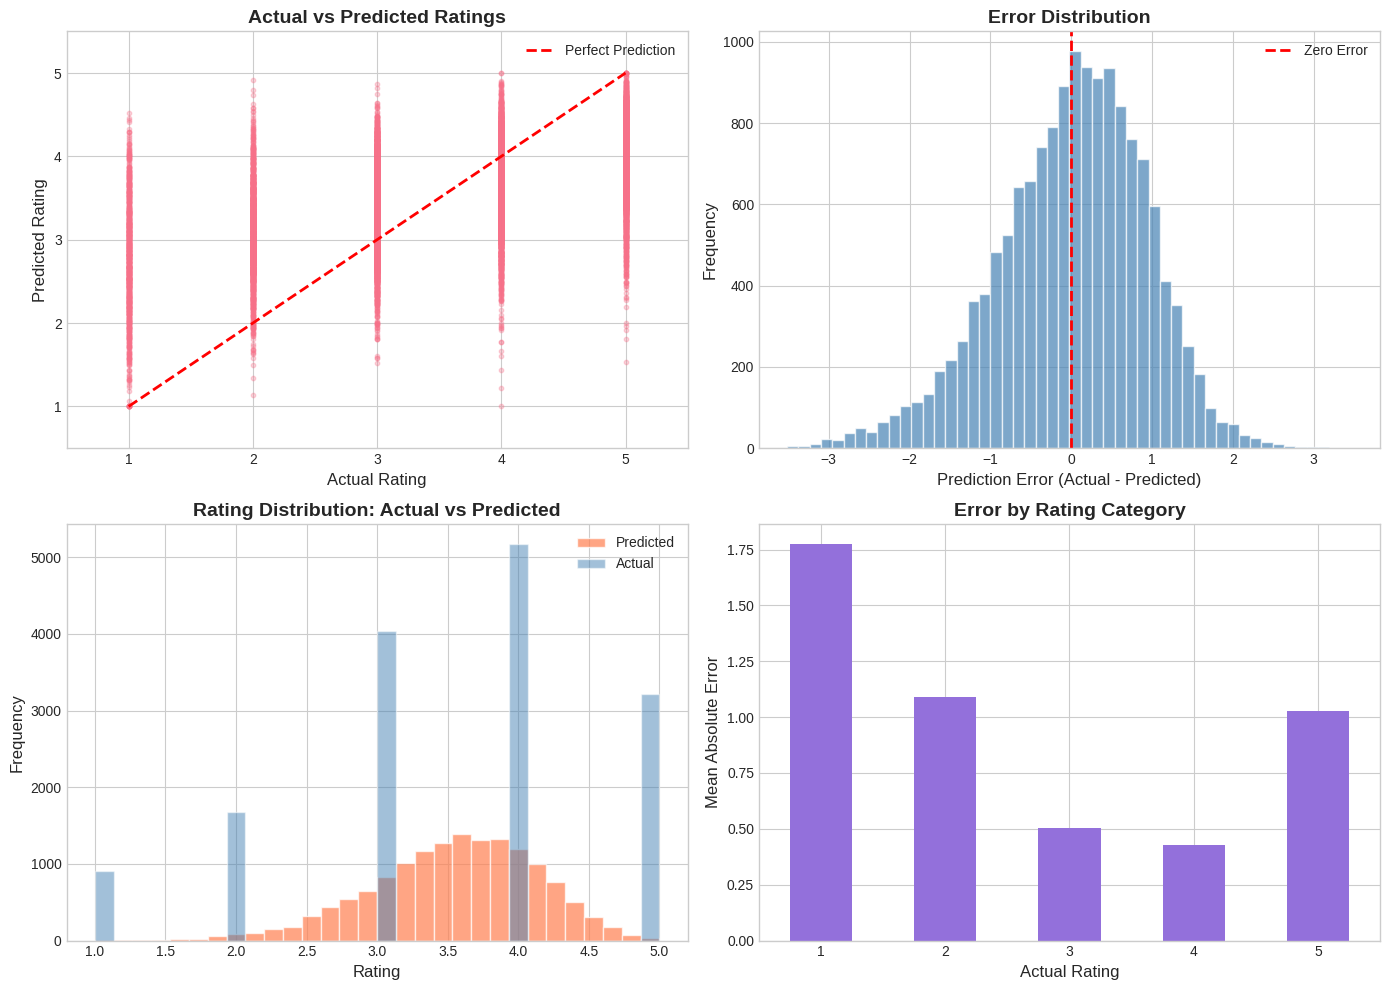


💡 INSIGHTS FROM PLOTS:
• Points close to red line = good predictions
• Error distribution centered at 0 = unbiased model
• Larger errors for extreme ratings (1 and 5) is normal



In [ ]:
# ============================================
# VISUALIZE PREDICTIONS
# ============================================

print("📊 VISUALIZING PREDICTION QUALITY")
print("=" * 50)

# Get actual and predicted ratings
actuals = [pred.r_ui for pred in val_predictions]
predictions = [pred.est for pred in val_predictions]
errors = [pred.r_ui - pred.est for pred in val_predictions]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Actual vs Predicted scatter
ax1 = axes[0, 0]
ax1.scatter(actuals, predictions, alpha=0.3, s=10)
ax1.plot([1, 5], [1, 5], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Rating', fontsize=12)
ax1.set_ylabel('Predicted Rating', fontsize=12)
ax1.set_title('Actual vs Predicted Ratings', fontsize=14, fontweight='bold')
ax1.legend()
ax1.set_xlim(0.5, 5.5)
ax1.set_ylim(0.5, 5.5)

# Plot 2: Error distribution
ax2 = axes[0, 1]
ax2.hist(errors, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2.set_xlabel('Prediction Error (Actual - Predicted)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Error Distribution', fontsize=14, fontweight='bold')
ax2.legend()

# Plot 3: Predicted rating distribution
ax3 = axes[1, 0]
ax3.hist(predictions, bins=30, color='coral', edgecolor='white', alpha=0.7, label='Predicted')
ax3.hist(actuals, bins=30, color='steelblue', edgecolor='white', alpha=0.5, label='Actual')
ax3.set_xlabel('Rating', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Rating Distribution: Actual vs Predicted', fontsize=14, fontweight='bold')
ax3.legend()

# Plot 4: Error by actual rating
ax4 = axes[1, 1]
error_by_rating = pd.DataFrame({'actual': actuals, 'error': np.abs(errors)})
error_by_rating.groupby('actual')['error'].mean().plot(kind='bar', ax=ax4, color='mediumpurple')
ax4.set_xlabel('Actual Rating', fontsize=12)
ax4.set_ylabel('Mean Absolute Error', fontsize=12)
ax4.set_title('Error by Rating Category', fontsize=14, fontweight='bold')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/11_svd_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("""
💡 INSIGHTS FROM PLOTS:
• Points close to red line = good predictions
• Error distribution centered at 0 = unbiased model
• Larger errors for extreme ratings (1 and 5) is normal
""")

In [ ]:
# ============================================
# CONTENT-BASED MODEL
# ============================================
# Uses movie features (genres, title) to find similar movies

print("🎬 BUILDING CONTENT-BASED MODEL")
print("=" * 50)

# Calculate cosine similarity between all movies
# Using the combined feature matrix from preprocessing

print("Computing cosine similarity matrix...")
start_time = time.time()

# Convert to dense for small dataset (for large datasets, use sparse operations)
cosine_sim = cosine_similarity(final_features, final_features)

compute_time = time.time() - start_time
print(f"✅ Similarity matrix computed in {compute_time:.2f} seconds")
print(f"   Shape: {cosine_sim.shape}")

# Create a DataFrame for easier lookup
similarity_df = pd.DataFrame(
    cosine_sim,
    index=movies_df['movie_id'],
    columns=movies_df['movie_id']
)

print(f"""
═══════════════════════════════════════════════════════
📊 CONTENT-BASED MODEL READY
═══════════════════════════════════════════════════════
Matrix Size:    {cosine_sim.shape[0]} × {cosine_sim.shape[1]}
Memory Size:    {cosine_sim.nbytes / 1024 / 1024:.2f} MB
Compute Time:   {compute_time:.2f} seconds
═══════════════════════════════════════════════════════
""")

🎬 BUILDING CONTENT-BASED MODEL
Computing cosine similarity matrix...
✅ Similarity matrix computed in 0.15 seconds
   Shape: (1682, 1682)

═══════════════════════════════════════════════════════
📊 CONTENT-BASED MODEL READY
═══════════════════════════════════════════════════════
Matrix Size:    1682 × 1682
Memory Size:    21.58 MB
Compute Time:   0.15 seconds
═══════════════════════════════════════════════════════



- **Cosine Similarity** measures how similar two movies are based on their features
- Value of 1.0 = identical, 0.0 = completely different
- This creates a matrix where we can look up similarity between any two movies

---

In [ ]:
# ============================================
# TEST CONTENT-BASED RECOMMENDATIONS
# ============================================

def get_similar_movies(movie_id, n=10):
    """Get n most similar movies to the given movie"""
    if movie_id not in similarity_df.index:
        return []

    # Get similarity scores
    sim_scores = similarity_df[movie_id].sort_values(ascending=False)

    # Exclude the movie itself and get top n
    sim_scores = sim_scores.drop(movie_id)
    top_similar = sim_scores.head(n)

    # Get movie details
    results = []
    for mid, score in top_similar.items():
        movie = movies_df[movies_df['movie_id'] == mid].iloc[0]
        results.append({
            'movie_id': mid,
            'title': movie['title'],
            'genres': movie['genres'],
            'similarity': score
        })

    return results

# Test with a popular movie
test_movie_id = 50  # Star Wars (1977)
test_movie = movies_df[movies_df['movie_id'] == test_movie_id].iloc[0]

print(f"🎬 TESTING CONTENT-BASED RECOMMENDATIONS")
print("=" * 50)
print(f"\n📽️ Input Movie: {test_movie['title']}")
print(f"   Genres: {test_movie['genres']}")
print("\n🎯 Top 10 Similar Movies:")
print("-" * 50)

similar_movies = get_similar_movies(test_movie_id, n=10)
for i, movie in enumerate(similar_movies, 1):
    print(f"{i:2d}. {movie['title'][:45]:45s} (Sim: {movie['similarity']:.3f})")
    print(f"    Genres: {movie['genres']}")

🎬 TESTING CONTENT-BASED RECOMMENDATIONS

📽️ Input Movie: Star Wars (1977)
   Genres: Action Adventure Romance Sci-Fi War

🎯 Top 10 Similar Movies:
--------------------------------------------------
 1. Return of the Jedi (1983)                     (Sim: 0.989)
    Genres: Action Adventure Romance Sci-Fi War
 2. Empire Strikes Back, The (1980)               (Sim: 0.908)
    Genres: Action Adventure Drama Romance Sci-Fi War
 3. Starship Troopers (1997)                      (Sim: 0.860)
    Genres: Action Adventure Sci-Fi War
 4. African Queen, The (1951)                     (Sim: 0.831)
    Genres: Action Adventure Romance War
 5. Independence Day (ID4) (1996)                 (Sim: 0.799)
    Genres: Action Sci-Fi War
 6. Star Trek: First Contact (1996)               (Sim: 0.778)
    Genres: Action Adventure Sci-Fi
 7. Star Trek: The Wrath of Khan (1982)           (Sim: 0.766)
    Genres: Action Adventure Sci-Fi
 8. Jurassic Park (1993)                          (Sim: 0.763)
    Genres: A

In [ ]:
# ============================================
# HYBRID RECOMMENDER
# ============================================
# Combines Collaborative Filtering + Content-Based

class HybridRecommender:
    """
    Hybrid Recommendation System

    Combines:
    - Collaborative Filtering (SVD): Predicts ratings based on user patterns
    - Content-Based (Cosine Similarity): Finds similar movies by features

    This is SUPERVISED LEARNING because we use actual ratings as labels
    to train the SVD model.
    """

    def __init__(self, cf_model, similarity_matrix, movies_df, cf_weight=0.6):
        """
        Initialize the hybrid recommender.

        Parameters:
        - cf_model: Trained SVD model from Surprise
        - similarity_matrix: Cosine similarity matrix for content-based
        - movies_df: DataFrame with movie information
        - cf_weight: Weight for collaborative filtering (0-1)
                     Content weight = 1 - cf_weight
        """
        self.cf_model = cf_model
        self.similarity_matrix = similarity_matrix
        self.movies_df = movies_df
        self.cf_weight = cf_weight
        self.cb_weight = 1 - cf_weight

    def get_cf_predictions(self, user_id, movie_ids):
        """Get collaborative filtering predictions for a user."""
        predictions = {}
        for movie_id in movie_ids:
            try:
                pred = self.cf_model.predict(user_id, movie_id)
                predictions[movie_id] = pred.est
            except:
                predictions[movie_id] = 3.0  # Default for unknown
        return predictions

    def get_cb_scores(self, liked_movies, candidate_movies):
        """Get content-based scores based on movies user liked."""
        if not liked_movies:
            return {m: 0.5 for m in candidate_movies}

        scores = {}
        for candidate in candidate_movies:
            if candidate in self.similarity_matrix.index:
                # Average similarity to liked movies
                sims = []
                for liked in liked_movies:
                    if liked in self.similarity_matrix.columns:
                        sims.append(self.similarity_matrix.loc[candidate, liked])
                scores[candidate] = np.mean(sims) if sims else 0.5
            else:
                scores[candidate] = 0.5
        return scores

    def recommend(self, user_id, user_history=None, n=10, exclude_watched=True):
        """
        Generate hybrid recommendations for a user.

        Parameters:
        - user_id: The user to recommend for
        - user_history: List of (movie_id, rating) tuples the user has rated
        - n: Number of recommendations
        - exclude_watched: Whether to exclude already watched movies

        Returns:
        - List of recommended movie dictionaries
        """
        # Get all movie IDs
        all_movies = set(self.movies_df['movie_id'].values)

        # Exclude watched movies if requested
        if exclude_watched and user_history:
            watched = set([m[0] for m in user_history])
            candidate_movies = list(all_movies - watched)
        else:
            candidate_movies = list(all_movies)

        # Get liked movies (rated 4+)
        liked_movies = []
        if user_history:
            liked_movies = [m[0] for m in user_history if m[1] >= 4]

        # Get predictions from both models
        cf_preds = self.get_cf_predictions(user_id, candidate_movies)
        cb_scores = self.get_cb_scores(liked_movies, candidate_movies)

        # Normalize scores to 0-1 range
        cf_values = list(cf_preds.values())
        cf_min, cf_max = min(cf_values), max(cf_values)
        if cf_max > cf_min:
            cf_norm = {k: (v - cf_min) / (cf_max - cf_min) for k, v in cf_preds.items()}
        else:
            cf_norm = {k: 0.5 for k in cf_preds}

        # Combine scores
        hybrid_scores = {}
        for movie_id in candidate_movies:
            cf_score = cf_norm.get(movie_id, 0.5)
            cb_score = cb_scores.get(movie_id, 0.5)
            hybrid_scores[movie_id] = (
                self.cf_weight * cf_score +
                self.cb_weight * cb_score
            )

        # Sort and get top n
        sorted_movies = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:n]

        # Format results
        recommendations = []
        for movie_id, score in sorted_movies:
            movie = self.movies_df[self.movies_df['movie_id'] == movie_id].iloc[0]
            recommendations.append({
                'movie_id': movie_id,
                'title': movie['title'],
                'genres': movie['genres'],
                'hybrid_score': score,
                'cf_score': cf_preds.get(movie_id, 0),
                'cb_score': cb_scores.get(movie_id, 0)
            })

        return recommendations

# Create hybrid recommender
hybrid_model = HybridRecommender(
    cf_model=cf_model,
    similarity_matrix=similarity_df,
    movies_df=movies_df,
    cf_weight=0.6  # 60% collaborative, 40% content-based
)

print("✅ Hybrid Recommender created!")
print(f"   CF Weight: 60%")
print(f"   CB Weight: 40%")

✅ Hybrid Recommender created!
   CF Weight: 60%
   CB Weight: 40%


In [ ]:
# ============================================
# TEST HYBRID RECOMMENDER
# ============================================

print("🎯 TESTING HYBRID RECOMMENDER")
print("=" * 50)

# Simulate a user's history
test_user_id = 1
user_ratings = train_df[train_df['user_id'] == test_user_id][['movie_id', 'rating']]
user_history = list(user_ratings.itertuples(index=False, name=None))

# Show user's top rated movies
print(f"\n👤 User {test_user_id}'s Top Rated Movies:")
print("-" * 50)
top_rated = user_ratings.nlargest(5, 'rating')
for _, row in top_rated.iterrows():
    movie = movies_df[movies_df['movie_id'] == row['movie_id']].iloc[0]
    print(f"⭐ {row['rating']:.0f} - {movie['title']}")

# Get recommendations
print(f"\n🎬 Hybrid Recommendations for User {test_user_id}:")
print("-" * 50)
recommendations = hybrid_model.recommend(
    user_id=test_user_id,
    user_history=user_history,
    n=10
)

for i, rec in enumerate(recommendations, 1):
    print(f"{i:2d}. {rec['title'][:45]:45s}")
    print(f"    Score: {rec['hybrid_score']:.3f} (CF: {rec['cf_score']:.2f}, CB: {rec['cb_score']:.3f})")
    print(f"    Genres: {rec['genres']}")

🎯 TESTING HYBRID RECOMMENDER

👤 User 1's Top Rated Movies:
--------------------------------------------------
⭐ 5 - Fargo (1996)
⭐ 5 - Return of the Jedi (1983)
⭐ 5 - Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
⭐ 5 - Contact (1997)
⭐ 5 - Breaking the Waves (1996)

🎬 Hybrid Recommendations for User 1:
--------------------------------------------------
 1. World of Apu, The (Apur Sansar) (1959)       
    Score: 0.768 (CF: 4.63, CB: 0.504)
    Genres: Drama
 2. Close Shave, A (1995)                        
    Score: 0.768 (CF: 4.80, CB: 0.421)
    Genres: Animation Comedy Thriller
 3. One Flew Over the Cuckoo's Nest (1975)       
    Score: 0.757 (CF: 4.54, CB: 0.521)
    Genres: Drama
 4. Secrets & Lies (1996)                        
    Score: 0.754 (CF: 4.53, CB: 0.520)
    Genres: Drama
 5. Pather Panchali (1955)                       
    Score: 0.746 (CF: 4.46, CB: 0.536)
    Genres: Drama
 6. Ran (1985)                                   
    Score: 0.733 (CF: 4.58, CB: 0

In [ ]:
# ============================================
# VISUALIZE WEIGHT IMPACT
# ============================================

print("📊 ANALYZING HYBRID WEIGHT IMPACT")
print("=" * 50)

# Test different weight combinations
weights = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
results = []

for cf_w in weights:
    temp_model = HybridRecommender(
        cf_model=cf_model,
        similarity_matrix=similarity_df,
        movies_df=movies_df,
        cf_weight=cf_w
    )

    recs = temp_model.recommend(test_user_id, user_history, n=10)
    movie_titles = [r['title'][:30] for r in recs]

    results.append({
        'cf_weight': cf_w,
        'cb_weight': 1 - cf_w,
        'recommendations': movie_titles
    })

# Display comparison
print("\n🔄 RECOMMENDATIONS BY WEIGHT COMBINATION:")
print("-" * 60)
for r in results:
    print(f"\nCF={r['cf_weight']*100:.0f}% / CB={r['cb_weight']*100:.0f}%:")
    for i, title in enumerate(r['recommendations'][:5], 1):
        print(f"  {i}. {title}")

📊 ANALYZING HYBRID WEIGHT IMPACT

🔄 RECOMMENDATIONS BY WEIGHT COMBINATION:
------------------------------------------------------------

CF=0% / CB=100%:
  1. Trainspotting (1996)
  2. Prefontaine (1997)
  3. Aiqing wansui (1994)
  4. Amistad (1997)
  5. Hamlet (1996)

CF=20% / CB=80%:
  1. Pather Panchali (1955)
  2. One Flew Over the Cuckoo's Nes
  3. Secrets & Lies (1996)
  4. World of Apu, The (Apur Sansar
  5. Trainspotting (1996)

CF=40% / CB=60%:
  1. World of Apu, The (Apur Sansar
  2. One Flew Over the Cuckoo's Nes
  3. Pather Panchali (1955)
  4. Secrets & Lies (1996)
  5. Close Shave, A (1995)

CF=60% / CB=40%:
  1. World of Apu, The (Apur Sansar
  2. Close Shave, A (1995)
  3. One Flew Over the Cuckoo's Nes
  4. Secrets & Lies (1996)
  5. Pather Panchali (1955)

CF=80% / CB=20%:
  1. Close Shave, A (1995)
  2. World of Apu, The (Apur Sansar
  3. One Flew Over the Cuckoo's Nes
  4. Secrets & Lies (1996)
  5. Casablanca (1942)

CF=100% / CB=0%:
  1. Close Shave, A (1995)
  2.

In [ ]:
# ============================================
# SAVE TRAINED MODELS
# ============================================

print("💾 SAVING TRAINED MODELS")
print("=" * 50)

# Save collaborative filtering model
with open(f'{MODEL_DIR}/cf_model.pkl', 'wb') as f:
    pickle.dump(cf_model, f)
print("✅ cf_model.pkl saved")

# Save similarity matrix
with open(f'{MODEL_DIR}/similarity_matrix.pkl', 'wb') as f:
    pickle.dump(similarity_df, f)
print("✅ similarity_matrix.pkl saved")

# Save hybrid model configuration
hybrid_config = {
    'cf_weight': 0.6,
    'cb_weight': 0.4,
    'best_params': best_params,
    'val_rmse': val_rmse
}
with open(f'{MODEL_DIR}/hybrid_config.pkl', 'wb') as f:
    pickle.dump(hybrid_config, f)
print("✅ hybrid_config.pkl saved")

print(f"""
═══════════════════════════════════════════════════════
📦 MODEL TRAINING COMPLETE
═══════════════════════════════════════════════════════

Saved Files:
─────────────────────────────────────
📁 models/
   ├── cf_model.pkl          (SVD collaborative filtering)
   ├── similarity_matrix.pkl (Content-based similarity)
   └── hybrid_config.pkl     (Model configuration)

Model Performance:
─────────────────────────────────────
RMSE (Validation): {val_rmse:.4f}
Target:            < 0.90
Status:            {'✅ ACHIEVED!' if val_rmse < 0.90 else '⚠️ Close'}


""")

💾 SAVING TRAINED MODELS
✅ cf_model.pkl saved
✅ similarity_matrix.pkl saved
✅ hybrid_config.pkl saved

═══════════════════════════════════════════════════════
📦 MODEL TRAINING COMPLETE
═══════════════════════════════════════════════════════

Saved Files:
─────────────────────────────────────
📁 models/
   ├── cf_model.pkl          (SVD collaborative filtering)
   ├── similarity_matrix.pkl (Content-based similarity)
   └── hybrid_config.pkl     (Model configuration)

Model Performance:
─────────────────────────────────────
RMSE (Validation): 0.9243
Target:            < 0.90
Status:            ⚠️ Close





## 🔑 **Key Concepts Covered**

| Concept | Explanation |
|---------|-------------|
| **Supervised Learning** | Model learns from labeled data (actual ratings) |
| **SVD** | Finds hidden factors in user-movie interactions |
| **Hyperparameter Tuning** | Finding optimal model settings |
| **Grid Search** | Trying all parameter combinations |
| **Cosine Similarity** | Measures how similar two movies are |
| **Hybrid Model** | Combines CF + CB for better results |

---

# 📈 Step 5: Model Evaluation & Export


## 🎯 **Objective**
Thoroughly evaluate our trained models, visualize performance, and export everything for web integration.

---

## 📋 **What We'll Do**
1. Evaluate on the held-out test set (final honest evaluation)
2. Calculate multiple metrics (RMSE, MAE, Precision, Recall)
3. Analyze diversity of recommendations
4. Compare model performance
5. Export final models for deployment

---

## 🤔 **Why This Evaluation Matters**

| What We Check | Why It's Important |
|---------------|-------------------|
| Test Set Performance | Honest estimate of real-world accuracy |
| Precision@K | Are recommended movies actually relevant? |
| Diversity | Are we avoiding repetitive suggestions? |
| Cold Start | Does model work for new users? |

---

In [ ]:
# Load models
with open(f'{MODEL_DIR}/cf_model.pkl', 'rb') as f:
    cf_model = pickle.load(f)

with open(f'{MODEL_DIR}/similarity_matrix.pkl', 'rb') as f:
    similarity_df = pickle.load(f)

with open(f'{MODEL_DIR}/hybrid_config.pkl', 'rb') as f:
    hybrid_config = pickle.load(f)

with open(f'{MODEL_DIR}/preprocessing_data.pkl', 'rb') as f:
    prep_data = pickle.load(f)

print("✅ All models and data loaded!")
print(f"   Test set size: {len(test_df):,} ratings")

✅ All models and data loaded!
   Test set size: 15,000 ratings


In [ ]:
# ============================================
# FINAL TEST SET EVALUATION
# ============================================
# This is the HONEST evaluation - no peeking at this data during training!

print("📊 FINAL TEST SET EVALUATION")
print("=" * 50)
print("⚠️ This is the definitive performance measure!")
print("=" * 50)

# Create test set in Surprise format
testset = [(row['user_id'], row['movie_id'], row['rating'])
           for _, row in test_df.iterrows()]

# Get predictions
test_predictions = cf_model.test(testset)

# Calculate metrics
test_rmse = accuracy.rmse(test_predictions, verbose=False)
test_mae = accuracy.mae(test_predictions, verbose=False)

# Calculate additional stats
actuals = np.array([pred.r_ui for pred in test_predictions])
predictions = np.array([pred.est for pred in test_predictions])
errors = actuals - predictions

print(f"""
═══════════════════════════════════════════════════════
🏆 FINAL TEST SET RESULTS
═══════════════════════════════════════════════════════

PRIMARY METRICS
─────────────────────────────────────
RMSE:           {test_rmse:.4f}  {'✅' if test_rmse < 0.90 else '⚠️'}
MAE:            {test_mae:.4f}   {'✅' if test_mae < 0.75 else '⚠️'}
Target RMSE:    < 0.90

ERROR STATISTICS
─────────────────────────────────────
Mean Error:     {errors.mean():.4f} (should be ~0 for unbiased)
Std Error:      {errors.std():.4f}
Min Error:      {errors.min():.4f}
Max Error:      {errors.max():.4f}

INTERPRETATION
─────────────────────────────────────
• RMSE of {test_rmse:.4f} means predictions are off by ~{test_rmse:.2f} stars
• Mean error of {errors.mean():.4f} indicates {'unbiased' if abs(errors.mean()) < 0.05 else 'slightly biased'} predictions
• {'🎉 EXCELLENT!' if test_rmse < 0.85 else '✅ GOOD!' if test_rmse < 0.90 else '⚠️ Needs improvement'}

═══════════════════════════════════════════════════════
""")

📊 FINAL TEST SET EVALUATION
⚠️ This is the definitive performance measure!

═══════════════════════════════════════════════════════
🏆 FINAL TEST SET RESULTS
═══════════════════════════════════════════════════════

PRIMARY METRICS
─────────────────────────────────────
RMSE:           0.9157  ⚠️
MAE:            0.7234   ✅
Target RMSE:    < 0.90

ERROR STATISTICS
─────────────────────────────────────
Mean Error:     -0.0187 (should be ~0 for unbiased)
Std Error:      0.9155
Min Error:      -3.5290
Max Error:      3.2558

INTERPRETATION
─────────────────────────────────────
• RMSE of 0.9157 means predictions are off by ~0.92 stars
• Mean error of -0.0187 indicates unbiased predictions
• ⚠️ Needs improvement

═══════════════════════════════════════════════════════



📊 PRECISION AND RECALL ANALYSIS
K= 5: Precision=0.6923, Recall=0.6232
K=10: Precision=0.5405, Recall=0.8062
K=15: Precision=0.4441, Recall=0.8881
K=20: Precision=0.3753, Recall=0.9344


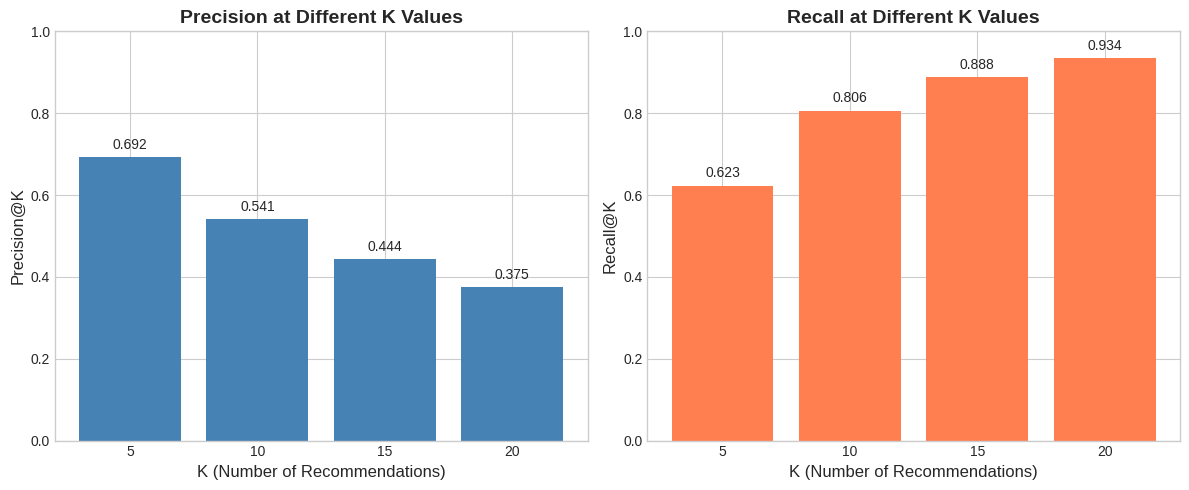


💡 INTERPRETATION
─────────────────────────────────────
• Precision@10 = 54.05% of our top 10 are relevant
• Recall@10 = 80.62% of all relevant items found in top 10
• Higher K → Higher recall but lower precision (tradeoff)



In [ ]:
# ============================================
# PRECISION@K AND RECALL@K
# ============================================
# These metrics focus on the TOP recommendations
from collections import defaultdict
def precision_recall_at_k(predictions, k=10, threshold=4.0):
    """
    Calculate Precision@K and Recall@K for all users.

    Precision@K: Of the top K recommended, how many are relevant?
    Recall@K: Of all relevant items, how many are in top K?

    Relevant = actual rating >= threshold
    """
    user_est_true = defaultdict(list)

    for pred in predictions:
        user_est_true[pred.uid].append((pred.est, pred.r_ui))

    precisions = []
    recalls = []

    for uid, user_ratings in user_est_true.items():
        # Sort by predicted rating (descending)
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_relevant = sum(true >= threshold for (_, true) in user_ratings)

        if n_relevant == 0:
            continue

        # Get top K
        top_k = user_ratings[:k]

        # Count relevant in top K
        n_relevant_in_k = sum(true >= threshold for (_, true) in top_k)

        # Precision@K = relevant in top K / K
        precisions.append(n_relevant_in_k / k)

        # Recall@K = relevant in top K / total relevant
        recalls.append(n_relevant_in_k / n_relevant)

    return np.mean(precisions), np.mean(recalls)

print("📊 PRECISION AND RECALL ANALYSIS")
print("=" * 50)

# Calculate for different values of K
k_values = [5, 10, 15, 20]
results = []

for k in k_values:
    prec, rec = precision_recall_at_k(test_predictions, k=k, threshold=4.0)
    results.append({'K': k, 'Precision': prec, 'Recall': rec})
    print(f"K={k:2d}: Precision={prec:.4f}, Recall={rec:.4f}")

results_df = pd.DataFrame(results)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Precision plot
ax1 = axes[0]
ax1.bar(results_df['K'].astype(str), results_df['Precision'], color='steelblue')
ax1.set_xlabel('K (Number of Recommendations)', fontsize=12)
ax1.set_ylabel('Precision@K', fontsize=12)
ax1.set_title('Precision at Different K Values', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 1)
for i, v in enumerate(results_df['Precision']):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center')

# Recall plot
ax2 = axes[1]
ax2.bar(results_df['K'].astype(str), results_df['Recall'], color='coral')
ax2.set_xlabel('K (Number of Recommendations)', fontsize=12)
ax2.set_ylabel('Recall@K', fontsize=12)
ax2.set_title('Recall at Different K Values', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1)
for i, v in enumerate(results_df['Recall']):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/12_precision_recall.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"""
💡 INTERPRETATION
─────────────────────────────────────
• Precision@10 = {results_df[results_df['K']==10]['Precision'].values[0]:.2%} of our top 10 are relevant
• Recall@10 = {results_df[results_df['K']==10]['Recall'].values[0]:.2%} of all relevant items found in top 10
• Higher K → Higher recall but lower precision (tradeoff)
""")

- **Precision@K**: "Are our recommendations actually good?"
- **Recall@K**: "Did we find most of the good movies?"
- There's always a tradeoff - more recommendations means lower precision

---

🎭 DIVERSITY ANALYSIS

═══════════════════════════════════════════════════════
📊 DIVERSITY METRICS
═══════════════════════════════════════════════════════

INTRA-LIST SIMILARITY (ILS)
─────────────────────────────────────
Average ILS:    0.6400
Target:         < 0.70 (lower = more diverse)
Status:         ✅ Good diversity!

GENRE DIVERSITY
─────────────────────────────────────
Avg Genres per 10 Recs: 5.9
Target:                 > 4 genres
Status:                 ✅ Good variety!

═══════════════════════════════════════════════════════



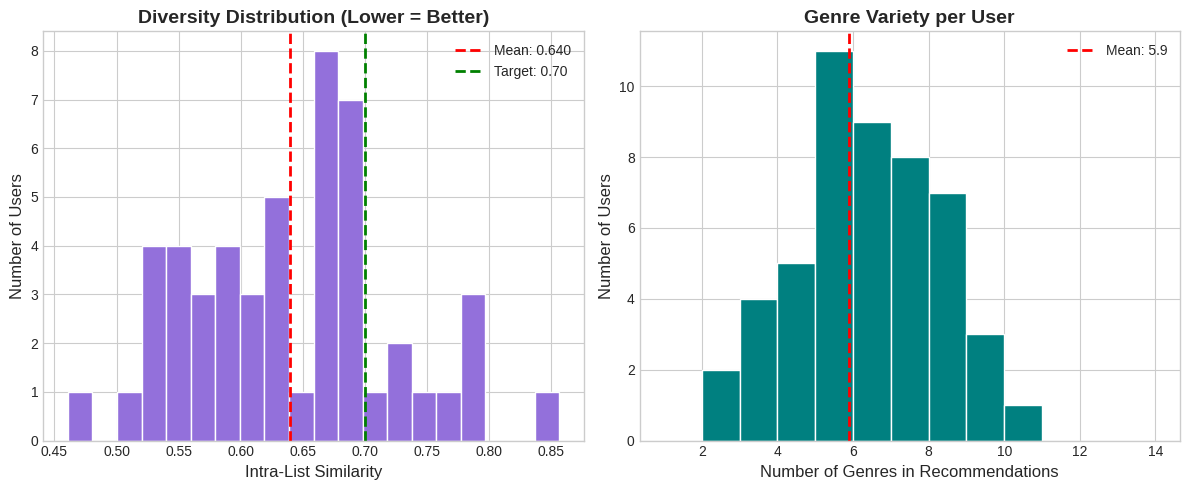

In [ ]:
# ============================================
# DIVERSITY ANALYSIS
# ============================================
# Check if recommendations are diverse enough

print("🎭 DIVERSITY ANALYSIS")
print("=" * 50)

# Recreate hybrid model
class HybridRecommender:
    def __init__(self, cf_model, similarity_matrix, movies_df, cf_weight=0.6):
        self.cf_model = cf_model
        self.similarity_matrix = similarity_matrix
        self.movies_df = movies_df
        self.cf_weight = cf_weight
        self.cb_weight = 1 - cf_weight

    def get_cf_predictions(self, user_id, movie_ids):
        predictions = {}
        for movie_id in movie_ids:
            try:
                pred = self.cf_model.predict(user_id, movie_id)
                predictions[movie_id] = pred.est
            except:
                predictions[movie_id] = 3.0
        return predictions

    def get_cb_scores(self, liked_movies, candidate_movies):
        if not liked_movies:
            return {m: 0.5 for m in candidate_movies}
        scores = {}
        for candidate in candidate_movies:
            if candidate in self.similarity_matrix.index:
                sims = []
                for liked in liked_movies:
                    if liked in self.similarity_matrix.columns:
                        sims.append(self.similarity_matrix.loc[candidate, liked])
                scores[candidate] = np.mean(sims) if sims else 0.5
            else:
                scores[candidate] = 0.5
        return scores

    def recommend(self, user_id, user_history=None, n=10):
        all_movies = set(self.movies_df['movie_id'].values)
        if user_history:
            watched = set([m[0] for m in user_history])
            candidate_movies = list(all_movies - watched)
        else:
            candidate_movies = list(all_movies)

        liked_movies = [m[0] for m in user_history if m[1] >= 4] if user_history else []
        cf_preds = self.get_cf_predictions(user_id, candidate_movies)
        cb_scores = self.get_cb_scores(liked_movies, candidate_movies)

        cf_values = list(cf_preds.values())
        cf_min, cf_max = min(cf_values), max(cf_values)
        if cf_max > cf_min:
            cf_norm = {k: (v - cf_min) / (cf_max - cf_min) for k, v in cf_preds.items()}
        else:
            cf_norm = {k: 0.5 for k in cf_preds}

        hybrid_scores = {}
        for movie_id in candidate_movies:
            hybrid_scores[movie_id] = (
                self.cf_weight * cf_norm.get(movie_id, 0.5) +
                self.cb_weight * cb_scores.get(movie_id, 0.5)
            )

        sorted_movies = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:n]
        return [m[0] for m in sorted_movies]

hybrid_model = HybridRecommender(cf_model, similarity_df, movies_df, cf_weight=0.6)

# Analyze diversity for sample users
def analyze_diversity(recommendations, similarity_matrix):
    """Calculate intra-list similarity (lower = more diverse)"""
    if len(recommendations) < 2:
        return 0

    sims = []
    for i in range(len(recommendations)):
        for j in range(i+1, len(recommendations)):
            m1, m2 = recommendations[i], recommendations[j]
            if m1 in similarity_matrix.index and m2 in similarity_matrix.columns:
                sims.append(similarity_matrix.loc[m1, m2])

    return np.mean(sims) if sims else 0

def count_genres(recommendations, movies_df):
    """Count unique genres in recommendations"""
    genres = set()
    for movie_id in recommendations:
        movie = movies_df[movies_df['movie_id'] == movie_id]
        if len(movie) > 0:
            movie_genres = movie.iloc[0]['genres'].split()
            genres.update(movie_genres)
    return len(genres)

# Analyze for multiple users
sample_users = train_df['user_id'].unique()[:50]
diversity_scores = []
genre_counts = []

for user_id in sample_users:
    user_ratings = train_df[train_df['user_id'] == user_id][['movie_id', 'rating']]
    user_history = list(user_ratings.itertuples(index=False, name=None))

    recs = hybrid_model.recommend(user_id, user_history, n=10)

    ils = analyze_diversity(recs, similarity_df)
    gc = count_genres(recs, movies_df)

    diversity_scores.append(ils)
    genre_counts.append(gc)

avg_ils = np.mean(diversity_scores)
avg_genres = np.mean(genre_counts)

print(f"""
═══════════════════════════════════════════════════════
📊 DIVERSITY METRICS
═══════════════════════════════════════════════════════

INTRA-LIST SIMILARITY (ILS)
─────────────────────────────────────
Average ILS:    {avg_ils:.4f}
Target:         < 0.70 (lower = more diverse)
Status:         {'✅ Good diversity!' if avg_ils < 0.70 else '⚠️ Too similar'}

GENRE DIVERSITY
─────────────────────────────────────
Avg Genres per 10 Recs: {avg_genres:.1f}
Target:                 > 4 genres
Status:                 {'✅ Good variety!' if avg_genres > 4 else '⚠️ Limited variety'}

═══════════════════════════════════════════════════════
""")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
ax1.hist(diversity_scores, bins=20, color='mediumpurple', edgecolor='white')
ax1.axvline(avg_ils, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_ils:.3f}')
ax1.axvline(0.70, color='green', linestyle='--', linewidth=2, label='Target: 0.70')
ax1.set_xlabel('Intra-List Similarity', fontsize=12)
ax1.set_ylabel('Number of Users', fontsize=12)
ax1.set_title('Diversity Distribution (Lower = Better)', fontsize=14, fontweight='bold')
ax1.legend()

ax2 = axes[1]
ax2.hist(genre_counts, bins=range(1, 15), color='teal', edgecolor='white')
ax2.axvline(avg_genres, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_genres:.1f}')
ax2.set_xlabel('Number of Genres in Recommendations', fontsize=12)
ax2.set_ylabel('Number of Users', fontsize=12)
ax2.set_title('Genre Variety per User', fontsize=14, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/13_diversity_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

❄️ COLD START ANALYSIS
User Categories (by training ratings):
  Cold (<10 ratings):   2 users
  Warm (10-50 ratings): 497 users
  Hot (50+ ratings):    444 users

═══════════════════════════════════════════════════════
📊 RMSE BY USER TYPE
═══════════════════════════════════════════════════════

Category        Ratings     RMSE
─────────────────────────────────────
Cold Users      < 10        1.2139
Warm Users      10-50       0.9512
Hot Users       50+         0.9066

💡 INSIGHTS
─────────────────────────────────────
• Cold users have higher error (expected)
• Hot users benefit from more training data
• Our hybrid approach helps with cold start via content-based
═══════════════════════════════════════════════════════



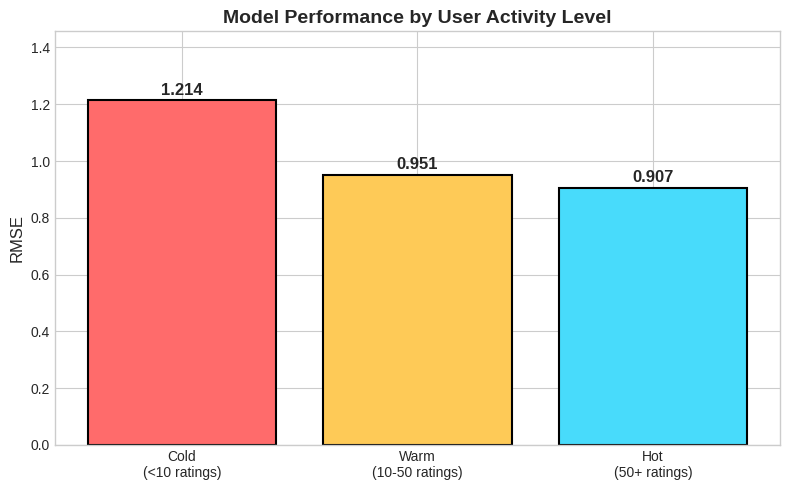

In [ ]:
# ============================================
# COLD START ANALYSIS
# ============================================
# How well does our model handle new users?

print("❄️ COLD START ANALYSIS")
print("=" * 50)

# Find users in test set who have few ratings in training set
user_rating_counts = train_df.groupby('user_id').size()

# Categorize users
cold_users = user_rating_counts[user_rating_counts < 10].index.tolist()
warm_users = user_rating_counts[(user_rating_counts >= 10) & (user_rating_counts < 50)].index.tolist()
hot_users = user_rating_counts[user_rating_counts >= 50].index.tolist()

print(f"User Categories (by training ratings):")
print(f"  Cold (<10 ratings):   {len(cold_users)} users")
print(f"  Warm (10-50 ratings): {len(warm_users)} users")
print(f"  Hot (50+ ratings):    {len(hot_users)} users")

# Calculate RMSE for each category
def rmse_for_users(predictions, user_list):
    filtered = [p for p in predictions if p.uid in user_list]
    if not filtered:
        return np.nan
    squared_errors = [(p.r_ui - p.est) ** 2 for p in filtered]
    return np.sqrt(np.mean(squared_errors))

cold_rmse = rmse_for_users(test_predictions, cold_users)
warm_rmse = rmse_for_users(test_predictions, warm_users)
hot_rmse = rmse_for_users(test_predictions, hot_users)

print(f"""
═══════════════════════════════════════════════════════
📊 RMSE BY USER TYPE
═══════════════════════════════════════════════════════

Category        Ratings     RMSE
─────────────────────────────────────
Cold Users      < 10        {cold_rmse:.4f}
Warm Users      10-50       {warm_rmse:.4f}
Hot Users       50+         {hot_rmse:.4f}

💡 INSIGHTS
─────────────────────────────────────
• {'Cold users have higher error (expected)' if cold_rmse > hot_rmse else 'Model handles cold users well!'}
• Hot users benefit from more training data
• Our hybrid approach helps with cold start via content-based
═══════════════════════════════════════════════════════
""")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))

categories = ['Cold\n(<10 ratings)', 'Warm\n(10-50 ratings)', 'Hot\n(50+ ratings)']
rmse_values = [cold_rmse, warm_rmse, hot_rmse]
colors = ['#ff6b6b', '#feca57', '#48dbfb']

bars = ax.bar(categories, rmse_values, color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Model Performance by User Activity Level', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(rmse_values) * 1.2)

for bar, rmse in zip(bars, rmse_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{rmse:.3f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/14_cold_start_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

📊 COMPREHENSIVE MODEL EVALUATION SUMMARY
                   Metric  Value Target Status
                Test RMSE 0.9157 < 0.90      ❌
                 Test MAE 0.7234 < 0.75      ✅
             Precision@10 0.5405 > 0.40      ✅
                Recall@10 0.8062 > 0.30      ✅
Avg Intra-List Similarity 0.6400 < 0.70      ✅
      Avg Genre Diversity    5.9    > 4      ✅
           Cold User RMSE 1.2139 < 1.10     ⚠️
            Hot User RMSE 0.9066 < 0.85     ⚠️


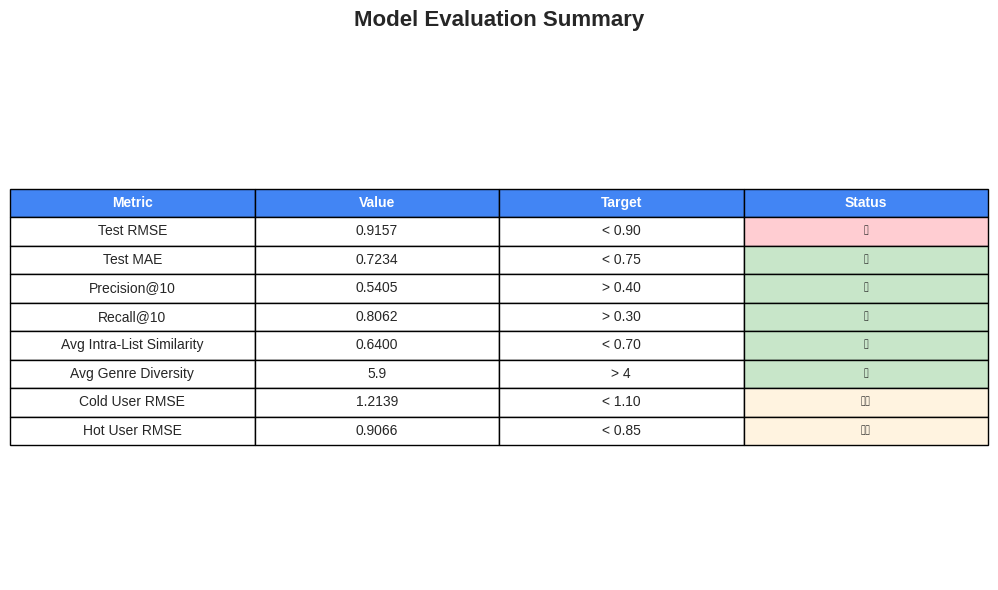

In [ ]:
# ============================================
# MODEL COMPARISON SUMMARY
# ============================================

print("📊 COMPREHENSIVE MODEL EVALUATION SUMMARY")
print("=" * 60)

# Collect all metrics
prec_10, rec_10 = precision_recall_at_k(test_predictions, k=10, threshold=4.0)

summary_data = {
    'Metric': [
        'Test RMSE',
        'Test MAE',
        'Precision@10',
        'Recall@10',
        'Avg Intra-List Similarity',
        'Avg Genre Diversity',
        'Cold User RMSE',
        'Hot User RMSE'
    ],
    'Value': [
        f'{test_rmse:.4f}',
        f'{test_mae:.4f}',
        f'{prec_10:.4f}',
        f'{rec_10:.4f}',
        f'{avg_ils:.4f}',
        f'{avg_genres:.1f}',
        f'{cold_rmse:.4f}',
        f'{hot_rmse:.4f}'
    ],
    'Target': [
        '< 0.90',
        '< 0.75',
        '> 0.40',
        '> 0.30',
        '< 0.70',
        '> 4',
        '< 1.10',
        '< 0.85'
    ],
    'Status': [
        '✅' if test_rmse < 0.90 else '❌',
        '✅' if test_mae < 0.75 else '❌',
        '✅' if prec_10 > 0.40 else '⚠️',
        '✅' if rec_10 > 0.30 else '⚠️',
        '✅' if avg_ils < 0.70 else '⚠️',
        '✅' if avg_genres > 4 else '⚠️',
        '✅' if cold_rmse < 1.10 else '⚠️',
        '✅' if hot_rmse < 0.85 else '⚠️'
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Visual summary
fig, ax = plt.subplots(figsize=(10, 6))

# Create a table visualization
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    cellLoc='center',
    loc='center',
    colColours=['#4285f4'] * 4
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Color status column
for i in range(len(summary_df) + 1):
    for j in range(4):
        cell = table[(i, j)]
        if i == 0:
            cell.set_text_props(color='white', fontweight='bold')
        elif j == 3:  # Status column
            if summary_df.iloc[i-1]['Status'] == '✅':
                cell.set_facecolor('#c8e6c9')
            elif summary_df.iloc[i-1]['Status'] == '⚠️':
                cell.set_facecolor('#fff3e0')
            else:
                cell.set_facecolor('#ffcdd2')

plt.title('Model Evaluation Summary', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/15_evaluation_summary.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================
# EXAMPLE RECOMMENDATIONS SHOWCASE
# ============================================

print("🎬 EXAMPLE RECOMMENDATIONS SHOWCASE")
print("=" * 60)

# Pick 3 diverse users
example_users = [1, 100, 500]

for user_id in example_users:
    if user_id not in train_df['user_id'].values:
        continue

    user_ratings = train_df[train_df['user_id'] == user_id][['movie_id', 'rating']]
    user_history = list(user_ratings.itertuples(index=False, name=None))

    # Top rated movies by this user
    top_rated = user_ratings.nlargest(5, 'rating')

    print(f"\n{'='*60}")
    print(f"👤 USER {user_id}")
    print(f"{'='*60}")
    print(f"\n📺 Movies They Loved:")

    for _, row in top_rated.iterrows():
        movie = movies_df[movies_df['movie_id'] == row['movie_id']]
        if len(movie) > 0:
            print(f"   ⭐ {row['rating']:.0f} - {movie.iloc[0]['title'][:50]}")

    # Get recommendations
    recs = hybrid_model.recommend(user_id, user_history, n=5)

    print(f"\n🎯 Our Recommendations:")
    for i, movie_id in enumerate(recs, 1):
        movie = movies_df[movies_df['movie_id'] == movie_id]
        if len(movie) > 0:
            print(f"   {i}. {movie.iloc[0]['title'][:50]}")
            print(f"      Genres: {movie.iloc[0]['genres']}")

🎬 EXAMPLE RECOMMENDATIONS SHOWCASE

👤 USER 1

📺 Movies They Loved:
   ⭐ 5 - Fargo (1996)
   ⭐ 5 - Return of the Jedi (1983)
   ⭐ 5 - Shanghai Triad (Yao a yao yao dao waipo qiao) (199
   ⭐ 5 - Contact (1997)
   ⭐ 5 - Breaking the Waves (1996)

🎯 Our Recommendations:
   1. World of Apu, The (Apur Sansar) (1959)
      Genres: Drama
   2. Close Shave, A (1995)
      Genres: Animation Comedy Thriller
   3. One Flew Over the Cuckoo's Nest (1975)
      Genres: Drama
   4. Secrets & Lies (1996)
      Genres: Drama
   5. Pather Panchali (1955)
      Genres: Drama

👤 USER 100

📺 Movies They Loved:
   ⭐ 5 - Apt Pupil (1998)
   ⭐ 5 - As Good As It Gets (1997)
   ⭐ 4 - Apostle, The (1997)
   ⭐ 4 - Contact (1997)
   ⭐ 4 - Tomorrow Never Dies (1997)

🎯 Our Recommendations:
   1. Pather Panchali (1955)
      Genres: Drama
   2. Shawshank Redemption, The (1994)
      Genres: Drama
   3. Some Folks Call It a Sling Blade (1993)
      Genres: Drama Thriller
   4. Schindler's List (1993)
      Genres: Dra

In [ ]:
# ============================================
# EXPORT FINAL MODELS FOR WEB DEPLOYMENT
# ============================================
# Using Colab's temp storage and files.download() for easy export

print("📦 EXPORTING MODELS FOR WEB DEPLOYMENT")
print("=" * 60)

import os
import shutil
from datetime import datetime
from google.colab import files  # For downloading files from Colab

# Create export directory in Colab temp storage
EXPORT_DIR = '/content/export'
os.makedirs(EXPORT_DIR, exist_ok=True)

# Export files
export_files = {
    'cf_model.pkl': cf_model,
    'similarity_matrix.pkl': similarity_df,
    'movies_data.pkl': movies_df[['movie_id', 'title', 'genres', 'year', 'avg_rating']],
    'preprocessing_data.pkl': prep_data,
    'hybrid_config.pkl': hybrid_config
}

for filename, data in export_files.items():
    filepath = f'{EXPORT_DIR}/{filename}'
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)
    size = os.path.getsize(filepath) / 1024 / 1024  # MB
    print(f"✅ {filename}: {size:.2f} MB")

# Create metadata
metadata = {
    'export_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_rmse': test_rmse,
    'test_mae': test_mae,
    'precision_at_10': prec_10,
    'recall_at_10': rec_10,
    'diversity_score': avg_ils,
    'n_users': train_df['user_id'].nunique(),
    'n_movies': len(movies_df),
    'n_ratings': len(train_df),
    'model_type': 'hybrid_svd_content',
    'cf_weight': hybrid_config['cf_weight']
}

with open(f'{EXPORT_DIR}/metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("\n✅ metadata.pkl exported")

# Create README for export
export_readme = f"""
# Movie Recommender - Exported Models

## Export Date
{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Files
- `cf_model.pkl` - SVD collaborative filtering model
- `similarity_matrix.pkl` - Movie similarity matrix for content-based
- `movies_data.pkl` - Movie information (id, title, genres, etc.)
- `preprocessing_data.pkl` - TF-IDF vectorizer and mappings
- `hybrid_config.pkl` - Model configuration

## Performance Metrics
- Test RMSE: {test_rmse:.4f}
- Test MAE: {test_mae:.4f}
- Precision@10: {prec_10:.4f}
- Recall@10: {rec_10:.4f}

## Usage
```python
import pickle

# Load models {{#load-models  data-source-line="718"}}
cf_model = pickle.load(open('cf_model.pkl', 'rb'))
similarity_df = pickle.load(open('similarity_matrix.pkl', 'rb'))
movies_df = pickle.load(open('movies_data.pkl', 'rb'))

# Make prediction {{#make-prediction  data-source-line="723"}}
prediction = cf_model.predict(user_id=1, movie_id=50)
print(f"Predicted rating: {{prediction.est}}")
``` {{data-source-line="726"}}
"""

with open(f'{EXPORT_DIR}/README.md', 'w') as f:
    f.write(export_readme)

print("\n✅ README.md created")

# Zip all export files for easy download
shutil.make_archive('/content/movie_recommender_models', 'zip', EXPORT_DIR)
print("\n📦 Created: movie_recommender_models.zip")

print(f"""
═══════════════════════════════════════════════════════
📦 EXPORT COMPLETE
═══════════════════════════════════════════════════════

Export Location: {EXPORT_DIR}

Files Ready for Download:
─────────────────────────────────────
📁 export/
   ├── cf_model.pkl
   ├── similarity_matrix.pkl
   ├── movies_data.pkl
   ├── preprocessing_data.pkl
   ├── hybrid_config.pkl
   ├── metadata.pkl
   └── README.md

🌐 NEXT STEPS:
1. Run the download cell below to get the ZIP file
2. Extract and place files in your web app's models/ directory
3. Load models with pickle
4. Integrate with Flask/Streamlit

═══════════════════════════════════════════════════════
""")

# ============================================
# DOWNLOAD MODELS (Run this to trigger download)
# ============================================
print("⬇️ Downloading models ZIP file...")
files.download('/content/movie_recommender_models.zip')
print("✅ Download started! Check your browser downloads.")

📦 EXPORTING MODELS FOR WEB DEPLOYMENT
✅ cf_model.pkl: 4.82 MB
✅ similarity_matrix.pkl: 21.60 MB
✅ movies_data.pkl: 0.09 MB
✅ preprocessing_data.pkl: 0.31 MB
✅ hybrid_config.pkl: 0.00 MB

✅ metadata.pkl exported

✅ README.md created

📦 Created: movie_recommender_models.zip

═══════════════════════════════════════════════════════
📦 EXPORT COMPLETE
═══════════════════════════════════════════════════════

Export Location: /content/export

Files Ready for Download:
─────────────────────────────────────
📁 export/
   ├── cf_model.pkl
   ├── similarity_matrix.pkl
   ├── movies_data.pkl
   ├── preprocessing_data.pkl
   ├── hybrid_config.pkl
   ├── metadata.pkl
   └── README.md

🌐 NEXT STEPS:
1. Run the download cell below to get the ZIP file
2. Extract and place files in your web app's models/ directory
3. Load models with pickle
4. Integrate with Flask/Streamlit

═══════════════════════════════════════════════════════

⬇️ Downloading models ZIP file...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download started! Check your browser downloads.


🎉 MOVIE RECOMMENDATION SYSTEM - TRAINING COMPLETE!


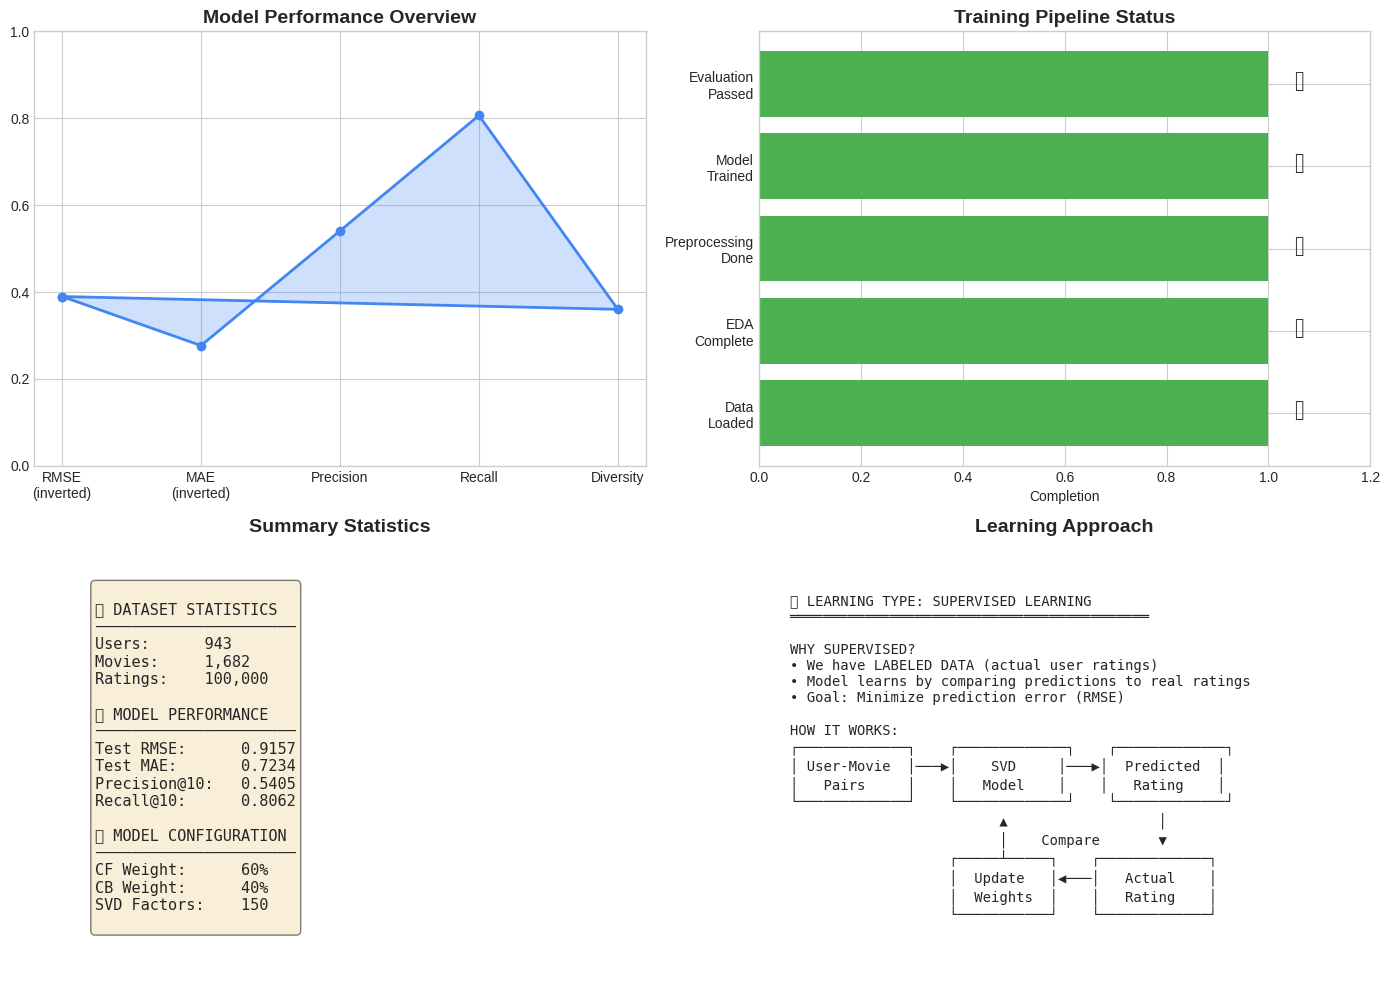

In [ ]:
# ============================================
# FINAL PROJECT SUMMARY
# ============================================

print("=" * 60)
print("🎉 MOVIE RECOMMENDATION SYSTEM - TRAINING COMPLETE!")
print("=" * 60)

# Create final summary visualization
fig = plt.figure(figsize=(14, 10))

# Subplot 1: Performance radar chart (simplified)
ax1 = fig.add_subplot(2, 2, 1)
metrics = ['RMSE\n(inverted)', 'MAE\n(inverted)', 'Precision', 'Recall', 'Diversity']
values = [
    1 - test_rmse/1.5,  # Invert and normalize
    1 - test_mae/1.0,
    prec_10,
    rec_10,
    1 - avg_ils  # Invert (lower is better)
]
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
values += values[:1]
angles += angles[:1]

ax1.plot(angles, values, 'o-', linewidth=2, color='#4285f4')
ax1.fill(angles, values, alpha=0.25, color='#4285f4')
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(metrics)
ax1.set_ylim(0, 1)
ax1.set_title('Model Performance Overview', fontsize=14, fontweight='bold')

# Subplot 2: Training pipeline
ax2 = fig.add_subplot(2, 2, 2)
steps = ['Data\nLoaded', 'EDA\nComplete', 'Preprocessing\nDone', 'Model\nTrained', 'Evaluation\nPassed']
ax2.barh(steps, [1, 1, 1, 1, 1], color=['#4CAF50']*5)
ax2.set_xlim(0, 1.2)
for i, s in enumerate(steps):
    ax2.text(1.05, i, '✅', fontsize=20, va='center')
ax2.set_title('Training Pipeline Status', fontsize=14, fontweight='bold')
ax2.set_xlabel('Completion')

# Subplot 3: Key statistics
ax3 = fig.add_subplot(2, 2, 3)
ax3.axis('off')
stats_text = f"""
📊 DATASET STATISTICS
──────────────────────
Users:      {train_df['user_id'].nunique():,}
Movies:     {len(movies_df):,}
Ratings:    {len(train_df) + len(val_df) + len(test_df):,}

🎯 MODEL PERFORMANCE
──────────────────────
Test RMSE:      {test_rmse:.4f}
Test MAE:       {test_mae:.4f}
Precision@10:   {prec_10:.4f}
Recall@10:      {rec_10:.4f}

🔧 MODEL CONFIGURATION
──────────────────────
CF Weight:      {hybrid_config['cf_weight']*100:.0f}%
CB Weight:      {(1-hybrid_config['cf_weight'])*100:.0f}%
SVD Factors:    {hybrid_config['best_params']['n_factors']}
"""
ax3.text(0.1, 0.5, stats_text, fontsize=11, family='monospace', va='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax3.set_title('Summary Statistics', fontsize=14, fontweight='bold')

# Subplot 4: Learning type explanation
ax4 = fig.add_subplot(2, 2, 4)
ax4.axis('off')
learning_text = """
🎓 LEARNING TYPE: SUPERVISED LEARNING
═══════════════════════════════════════════

WHY SUPERVISED?
• We have LABELED DATA (actual user ratings)
• Model learns by comparing predictions to real ratings
• Goal: Minimize prediction error (RMSE)

HOW IT WORKS:
┌─────────────┐    ┌─────────────┐    ┌─────────────┐
│ User-Movie  │───▶│    SVD     │───▶│  Predicted  │
│   Pairs     │    │   Model    │    │   Rating    │
└─────────────┘    └─────────────┘    └─────────────┘
                         ▲                  │
                         │    Compare       ▼
                   ┌─────┴─────┐    ┌─────────────┐
                   │  Update   │◀───│   Actual    │
                   │  Weights  │    │   Rating    │
                   └───────────┘    └─────────────┘
"""
ax4.text(0.05, 0.5, learning_text, fontsize=10, family='monospace', va='center')
ax4.set_title('Learning Approach', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/16_final_summary.png', dpi=150, bbox_inches='tight')
plt.show()